# <div style="text-align: center;"> **CNN MODELS** </div>

----------------------------

In [20]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from import_images import create_image_dataset
from image_loader import LoadImage
from image_preprocesser import preprocess_image, apply_preprocessing
from callbacks_training_CNN import create_reduce_lr_callback, create_early_stopping_callback, establish_checkpoints , train_model
from metrics_CNN import plot_training_history, plot_confusion_matrix, plot_auc_curve
from extract_features import extract_features
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [2]:
#Directories 
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

### **Load and Preprocessing images**

In [3]:
#Import images
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None)
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.


I0000 00:00:1737443941.480215 1647300 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [4]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(256, 256)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

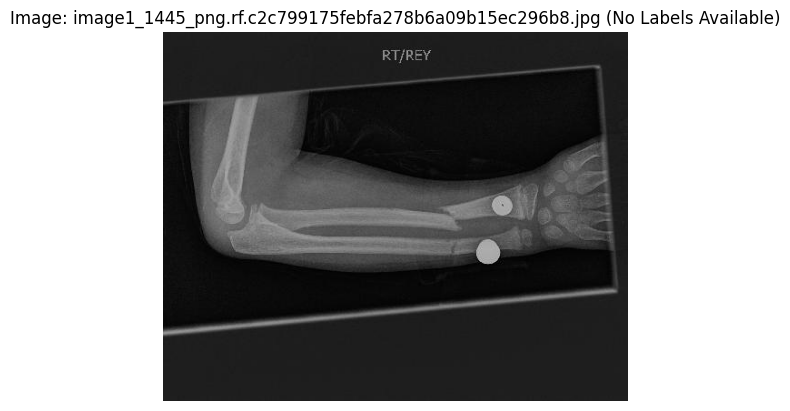

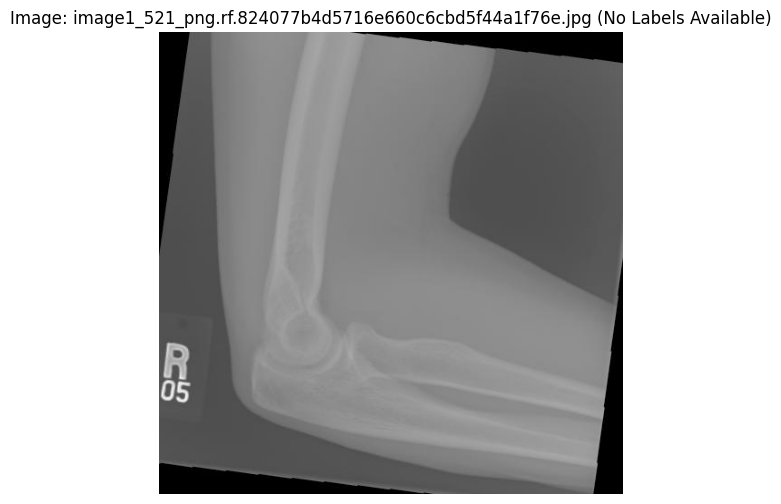

In [8]:
#Plot random images
loader = LoadImage(train_dir)
loader.plot_images_with_bboxes() 


----

### **Contruct a CNN**

### *Model 1*

In [5]:
#Construct the model 
model_CNN1 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN1.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN1.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN1.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN1.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN1.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN1.add(layers.Dense(1, activation='sigmoid'))

model_CNN1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

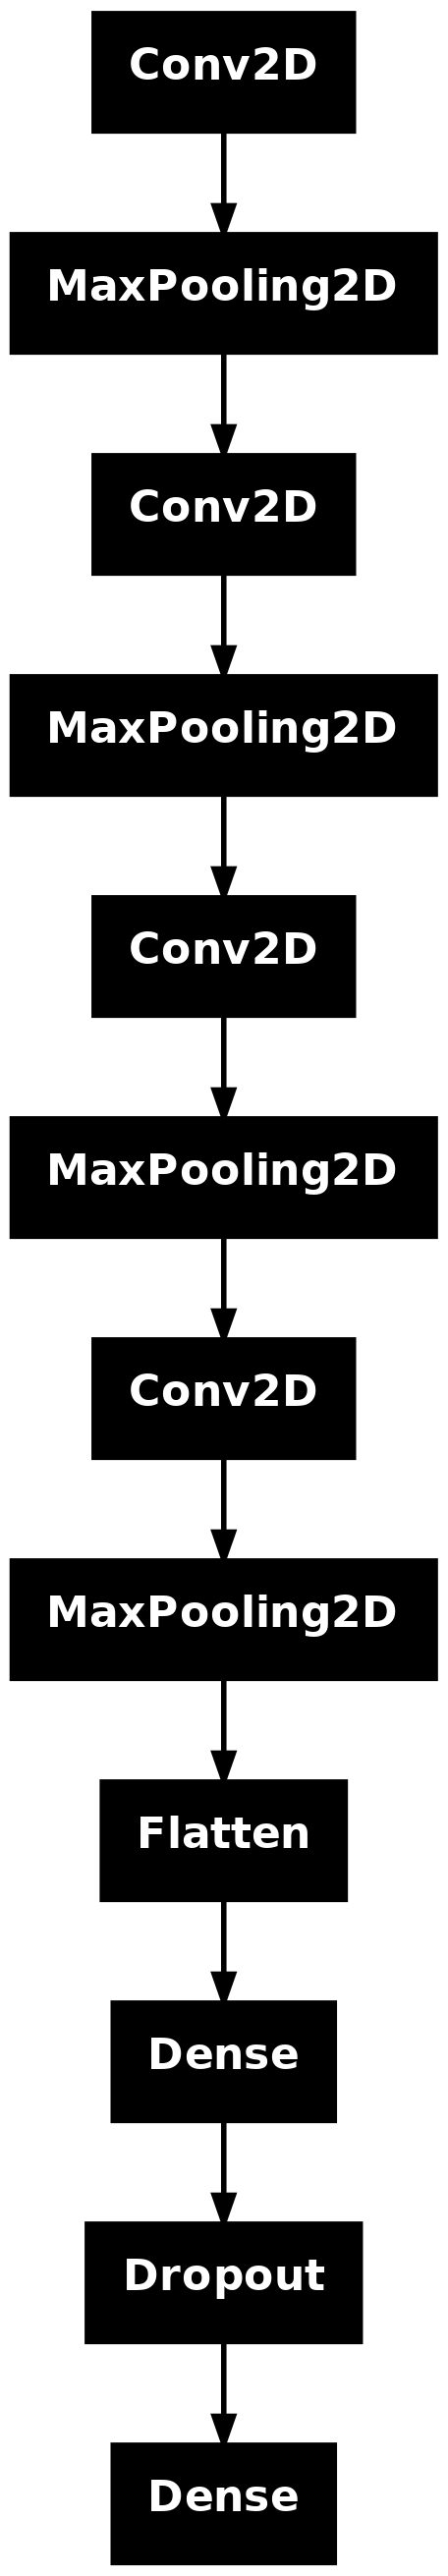

In [6]:
tf.keras.utils.plot_model(model_CNN1)

In [6]:
model_CNN1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [7]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback()

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback()

#Train the model 
history = train_model(model_CNN1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


I0000 00:00:1733400144.188271  254219 service.cc:148] XLA service 0x7f923000c010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733400144.188326  254219 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-05 13:02:24.356800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733400144.549334  254219 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-05 13:02:24.914760: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"

  3/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4722 - loss: 1.0055 

I0000 00:00:1733400148.465140  254219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5844 - loss: 0.7175

2024-12-05 13:02:35.247348: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-05 13:02:35.299485: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.5846 - loss: 0.7173 - val_accuracy: 0.4959 - val_loss: 0.6844 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5857 - loss: 0.6841

2024-12-05 13:02:37.879061: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-05 13:02:37.879097: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-05 13:02:37.879111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:02:37.879122: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trac

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6334 - loss: 0.6759 - val_accuracy: 0.4959 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5924 - loss: 0.6812 - val_accuracy: 0.5041 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6651 - loss: 0.6630

2024-12-05 13:02:45.540910: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-12-05 13:02:45.540947: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6167 - loss: 0.6732 - val_accuracy: 0.4992 - val_loss: 0.7029 - learning_rate: 0.0010


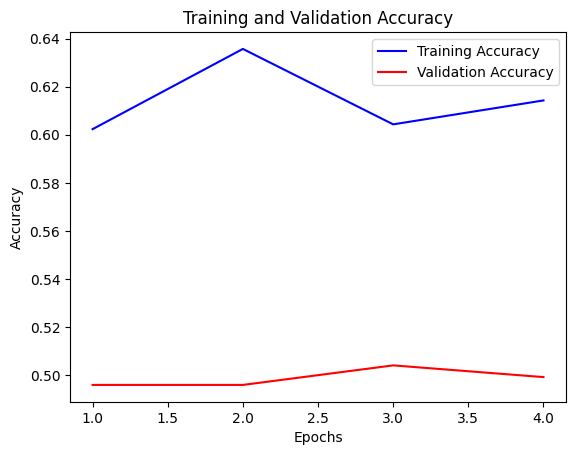

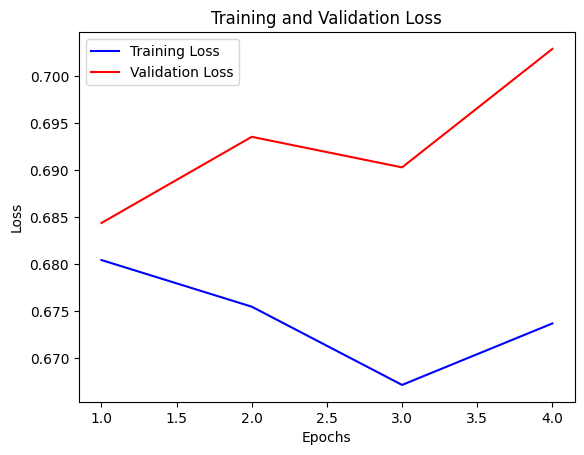

In [8]:
plot_training_history(history)

36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

2024-12-05 13:03:49.183060: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-05 13:03:49.311754: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Accuracy on test dataset: 0.4954

Classification Report:
               precision    recall  f1-score   support

    fracture       0.00      0.00      0.00       387
  nofracture       0.50      1.00      0.66       380

    accuracy                           0.50       767
   macro avg       0.25      0.50      0.33       767
weighted avg       0.25      0.50      0.33       767



/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

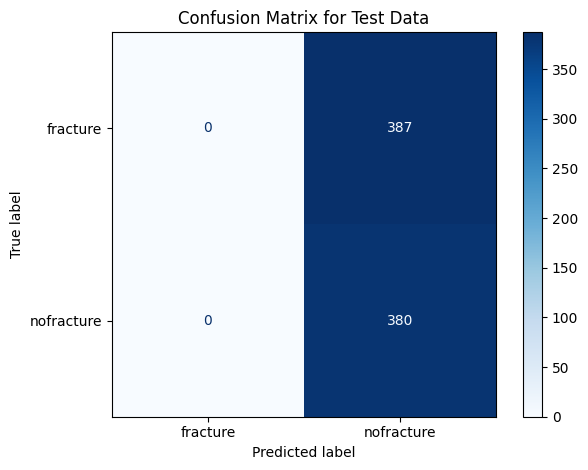

In [9]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
AUC: 0.4913


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


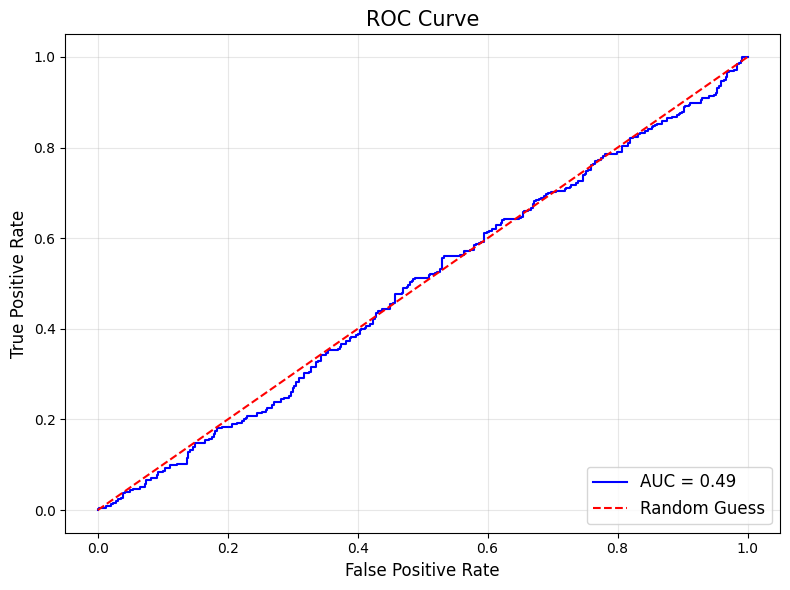

In [10]:
auc = plot_auc_curve(model_CNN1, test_ds)

------

In [11]:
#Same model but patient 10 instead of 3

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_CNN1, train_ds, epochs = 100, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5978 - loss: 0.6759 - val_accuracy: 0.4992 - val_loss: 0.7111 - learning_rate: 5.0000e-04
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6045 - loss: 0.6886

2024-12-05 13:04:06.026827: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-05 13:04:06.026857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:04:06.026876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6070 - loss: 0.6770 - val_accuracy: 0.4976 - val_loss: 0.6983 - learning_rate: 5.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5919 - loss: 0.6642 - val_accuracy: 0.5138 - val_loss: 0.7443 - learning_rate: 5.0000e-04
Epoch 4/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7189 - loss: 0.6153

2024-12-05 13:04:13.837623: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:04:13.837663: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6733 - loss: 0.6321 - val_accuracy: 0.5171 - val_loss: 0.6989 - learning_rate: 5.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6169 - loss: 0.6551 - val_accuracy: 0.5886 - val_loss: 0.6774 - learning_rate: 5.0000e-04
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6394 - loss: 0.6315

2024-12-05 13:04:21.641262: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6359 - loss: 0.6257 - val_accuracy: 0.5610 - val_loss: 0.6895 - learning_rate: 5.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6470 - loss: 0.6304 - val_accuracy: 0.5919 - val_loss: 0.7196 - learning_rate: 5.0000e-04
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6613 - loss: 0.5639

2024-12-05 13:04:29.169813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:04:29.169845: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6573 - loss: 0.5670 - val_accuracy: 0.6179 - val_loss: 0.6967 - learning_rate: 5.0000e-04
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6787 - loss: 0.5927 - val_accuracy: 0.6374 - val_loss: 0.7716 - learning_rate: 5.0000e-04
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7114 - loss: 0.5236

2024-12-05 13:04:36.833973: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7414 - loss: 0.5220 - val_accuracy: 0.6488 - val_loss: 0.7008 - learning_rate: 5.0000e-04
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7100 - loss: 0.5461 - val_accuracy: 0.6504 - val_loss: 0.7997 - learning_rate: 5.0000e-04
Epoch 12/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8147 - loss: 0.4262

2024-12-05 13:04:44.471958: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:04:44.471997: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8074 - loss: 0.4496 - val_accuracy: 0.6504 - val_loss: 0.7328 - learning_rate: 5.0000e-04
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7536 - loss: 0.4804 - val_accuracy: 0.6764 - val_loss: 0.8752 - learning_rate: 5.0000e-04
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7973 - loss: 0.3671

2024-12-05 13:04:52.167041: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:04:52.167072: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7999 - loss: 0.4188 - val_accuracy: 0.6927 - val_loss: 0.7434 - learning_rate: 5.0000e-04
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8052 - loss: 0.3946 - val_accuracy: 0.7122 - val_loss: 0.7857 - learning_rate: 5.0000e-04


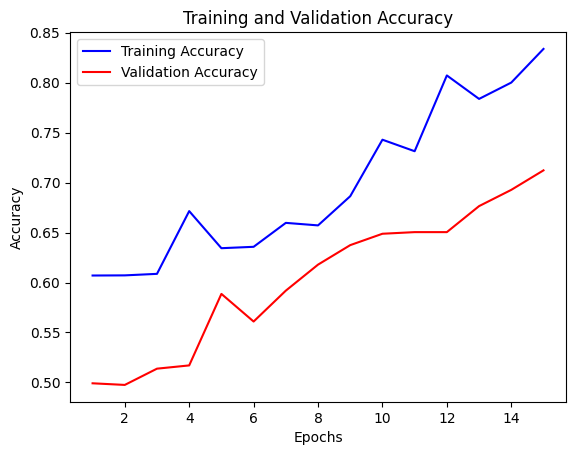

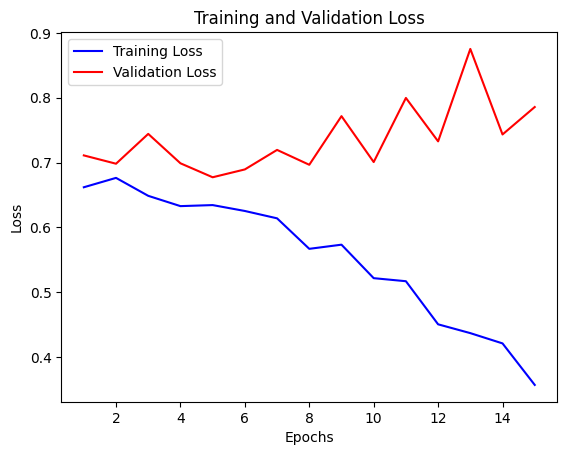

In [12]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy on test dataset: 0.5267

Classification Report:
               precision    recall  f1-score   support

    fracture       0.59      0.21      0.31       387
  nofracture       0.51      0.85      0.64       380

    accuracy                           0.53       767
   macro avg       0.55      0.53      0.47       767
weighted avg       0.55      0.53      0.47       767



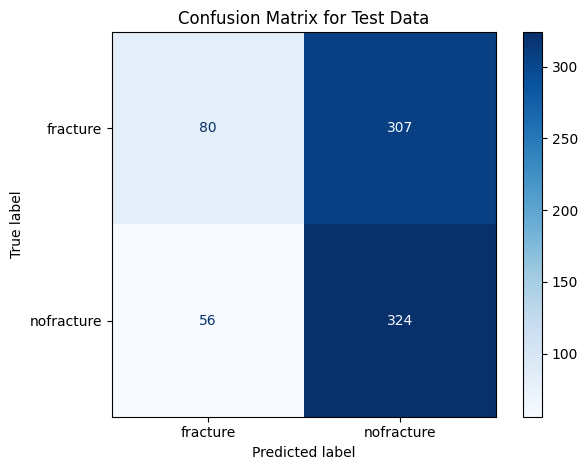

In [13]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
AUC: 0.4757


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


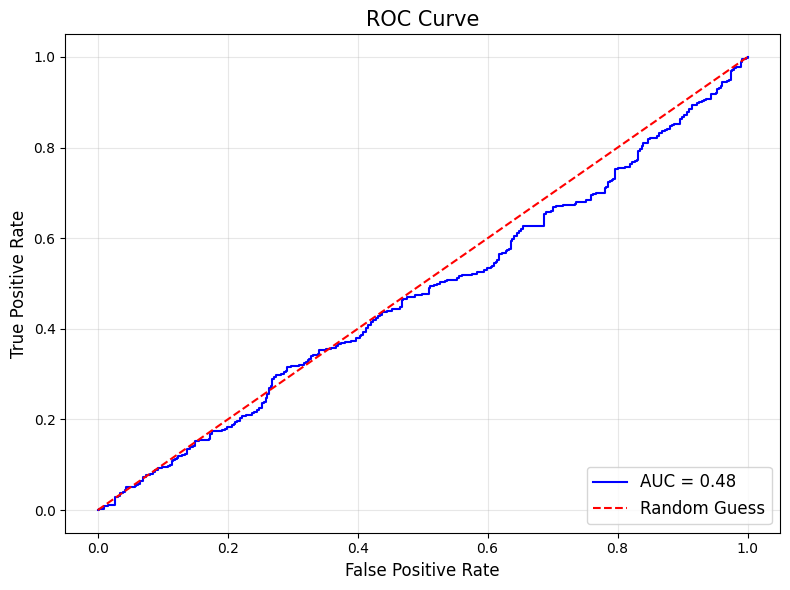

In [14]:
auc = plot_auc_curve(model_CNN1, test_ds)

----

In [15]:
optimizer = Adam(learning_rate=1e-4)
model_CNN1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [16]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.6495 - loss: 0.6182 - val_accuracy: 0.5967 - val_loss: 0.7105 - learning_rate: 1.0000e-04
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7404 - loss: 0.5379

2024-12-05 13:08:29.569856: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-05 13:08:29.569907: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7087 - loss: 0.5607 - val_accuracy: 0.5919 - val_loss: 0.7171 - learning_rate: 1.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6606 - loss: 0.6160 - val_accuracy: 0.6179 - val_loss: 0.7009 - learning_rate: 1.0000e-04
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7097 - loss: 0.5595

2024-12-05 13:08:37.361209: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:08:37.361245: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7209 - loss: 0.5403 - val_accuracy: 0.6146 - val_loss: 0.6991 - learning_rate: 1.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6867 - loss: 0.5830 - val_accuracy: 0.6390 - val_loss: 0.7020 - learning_rate: 1.0000e-04
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6732 - loss: 0.5434

2024-12-05 13:08:45.040097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:08:45.040128: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6987 - loss: 0.5394 - val_accuracy: 0.6309 - val_loss: 0.7128 - learning_rate: 1.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6938 - loss: 0.5657 - val_accuracy: 0.6488 - val_loss: 0.7142 - learning_rate: 1.0000e-04
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7286 - loss: 0.5737

2024-12-05 13:08:52.744890: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:08:52.744924: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7490 - loss: 0.5376 - val_accuracy: 0.6390 - val_loss: 0.7219 - learning_rate: 1.0000e-04
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7192 - loss: 0.5455 - val_accuracy: 0.6569 - val_loss: 0.6971 - learning_rate: 1.0000e-04
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7435 - loss: 0.5235

2024-12-05 13:09:00.602004: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-05 13:09:00.602032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:09:00.602045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7701 - loss: 0.4914 - val_accuracy: 0.6585 - val_loss: 0.7051 - learning_rate: 1.0000e-04
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7364 - loss: 0.5157 - val_accuracy: 0.6829 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7993 - loss: 0.4427

2024-12-05 13:09:08.306554: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7795 - loss: 0.4750 - val_accuracy: 0.6846 - val_loss: 0.7044 - learning_rate: 1.0000e-04
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7611 - loss: 0.4658 - val_accuracy: 0.6959 - val_loss: 0.7292 - learning_rate: 1.0000e-04
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8581 - loss: 0.3098

2024-12-05 13:09:16.102499: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:09:16.102539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7755 - loss: 0.4206 - val_accuracy: 0.6976 - val_loss: 0.7325 - learning_rate: 1.0000e-04
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7949 - loss: 0.4237 - val_accuracy: 0.7252 - val_loss: 0.7126 - learning_rate: 1.0000e-04
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8619 - loss: 0.3225

2024-12-05 13:09:23.805876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:09:23.805908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8710 - loss: 0.3077 - val_accuracy: 0.7252 - val_loss: 0.7364 - learning_rate: 1.0000e-04


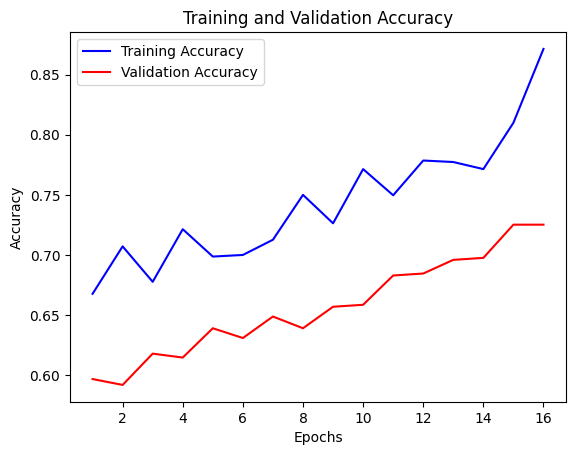

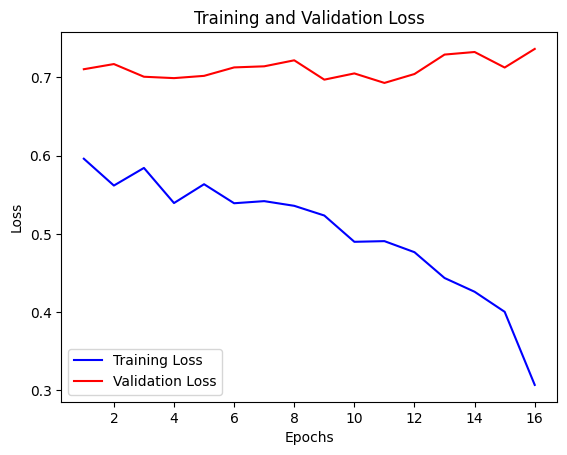

In [17]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Accuracy on test dataset: 0.5163

Classification Report:
               precision    recall  f1-score   support

    fracture       0.53      0.33      0.41       387
  nofracture       0.51      0.71      0.59       380

    accuracy                           0.52       767
   macro avg       0.52      0.52      0.50       767
weighted avg       0.52      0.52      0.50       767



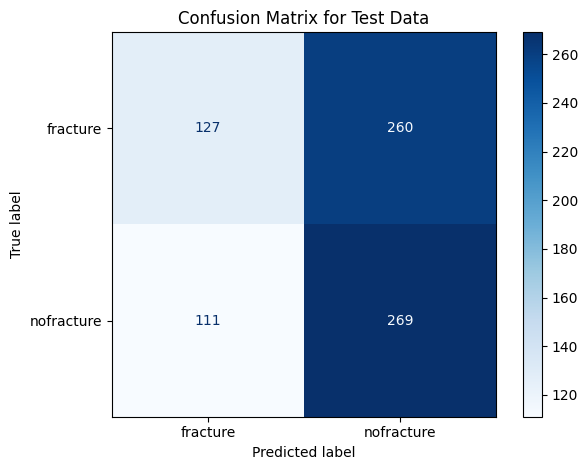

In [18]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
AUC: 0.4913


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


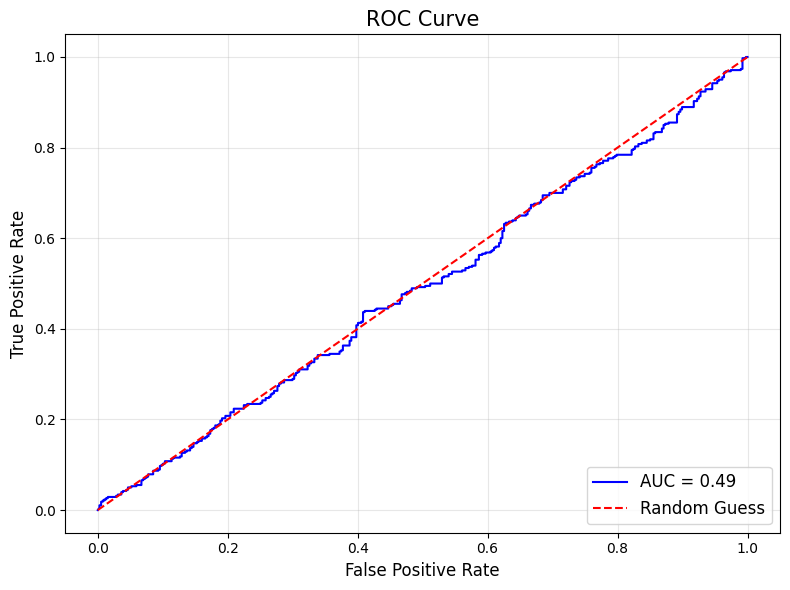

In [19]:
auc = plot_auc_curve(model_CNN1, test_ds)

------------

### *Model 2*

In [20]:
#Construct the model 
model_CNN2 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN2.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Dropout(0.3)) #add a dropout
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN2.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN2.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN2.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

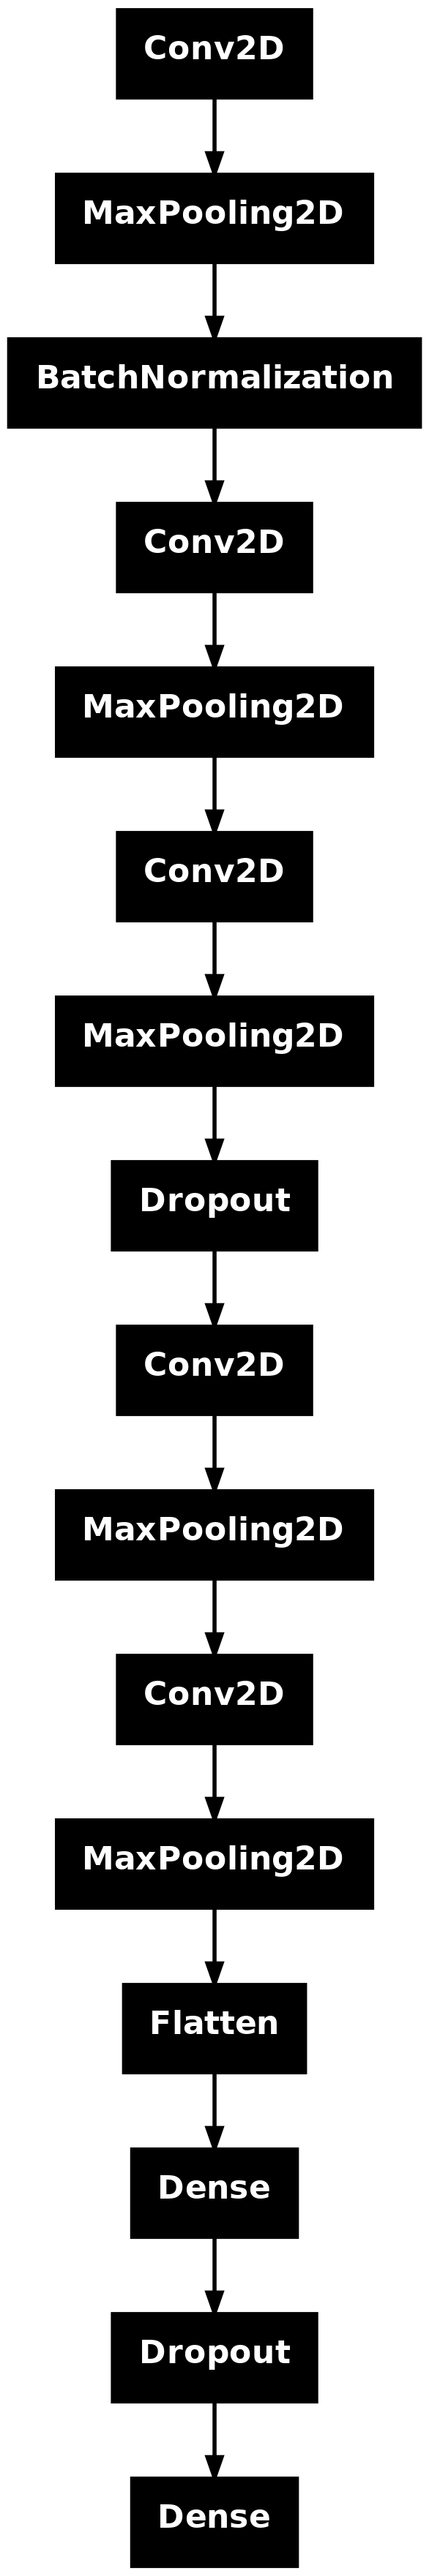

In [35]:
tf.keras.utils.plot_model(model_CNN2)

In [21]:
optimizer = Adam(learning_rate=1e-3)
model_CNN2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN2, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2024-12-05 13:10:36.790440: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5745 - loss: 0.7682

2024-12-05 13:10:45.603207: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-05 13:10:46.352743: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", bac

150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.5747 - loss: 0.7678 - val_accuracy: 0.4959 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6494 - loss: 0.6520

2024-12-05 13:10:47.002257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:10:47.002311: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6227 - loss: 0.6653 - val_accuracy: 0.4959 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5906 - loss: 0.6795 - val_accuracy: 0.4959 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6771 - loss: 0.6456

2024-12-05 13:10:54.690619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:10:54.690654: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6785 - loss: 0.6355 - val_accuracy: 0.4959 - val_loss: 0.7039 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5920 - loss: 0.6796 - val_accuracy: 0.4959 - val_loss: 0.6965 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6323 - loss: 0.6680

2024-12-05 13:11:02.435862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:11:02.435899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6560 - loss: 0.6631 - val_accuracy: 0.4959 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5949 - loss: 0.6733 - val_accuracy: 0.4959 - val_loss: 0.7688 - learning_rate: 0.0010
Epoch 8/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6593 - loss: 0.8003

2024-12-05 13:11:10.133222: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5818 - loss: 0.8548 - val_accuracy: 0.4959 - val_loss: 0.6973 - learning_rate: 0.0010


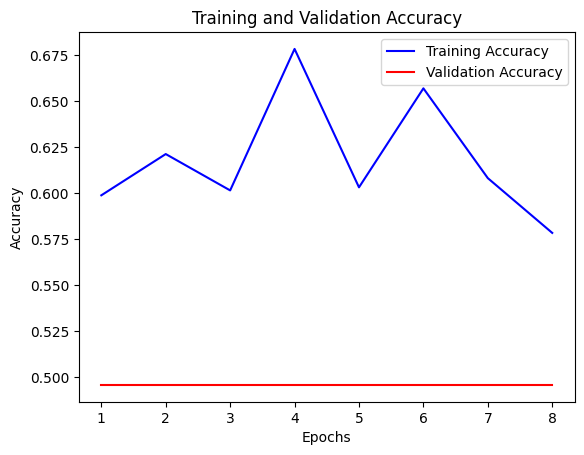

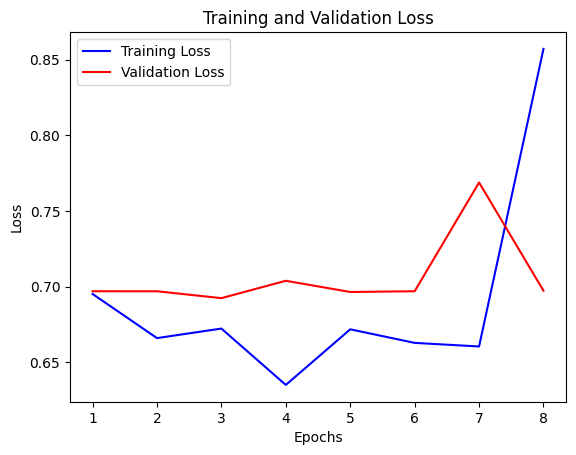

In [23]:
plot_training_history(history)

---------

### *Model 3*

In [24]:
#Construct the model 
model_CNN3 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN3.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))) #L2 regularization
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Dropout(0.4)) #add a dropout
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN3.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN3.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

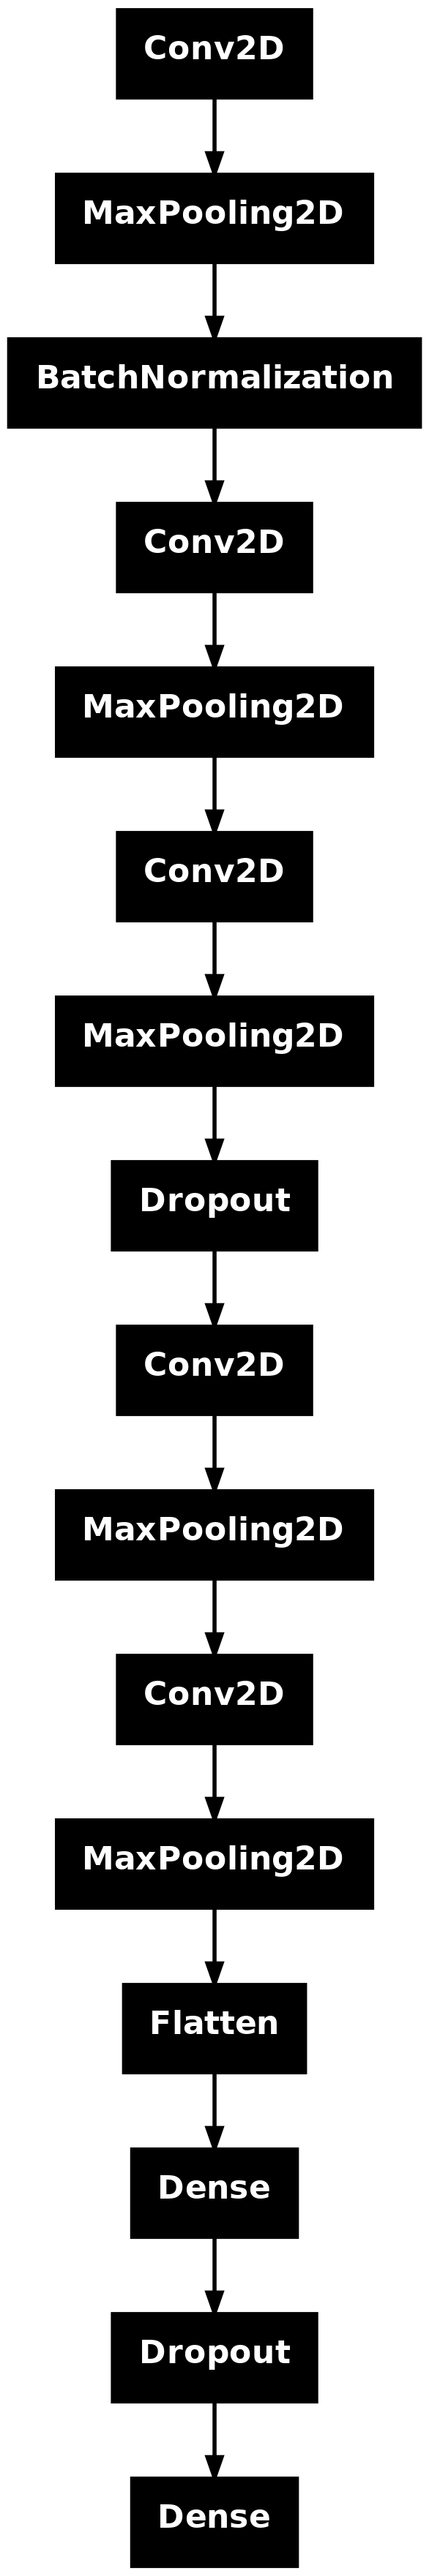

In [40]:
tf.keras.utils.plot_model(model_CNN3)

In [25]:
optimizer = Adam(learning_rate=1e-3)
model_CNN3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN3, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.5522 - loss: 7.1931 - val_accuracy: 0.4959 - val_loss: 1.2200 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5878 - loss: 1.2034

2024-12-05 13:14:25.105531: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:14:25.105577: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6062 - loss: 1.1698 - val_accuracy: 0.4959 - val_loss: 1.1697 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5889 - loss: 0.9997 - val_accuracy: 0.4959 - val_loss: 0.8044 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6155 - loss: 0.7653

2024-12-05 13:14:32.881107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:14:32.881139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6416 - loss: 0.7550 - val_accuracy: 0.4959 - val_loss: 0.8017 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5974 - loss: 0.7477 - val_accuracy: 0.4959 - val_loss: 0.7478 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6816 - loss: 0.6808

2024-12-05 13:14:40.498011: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:14:40.498047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6310 - loss: 0.6975 - val_accuracy: 0.4959 - val_loss: 0.7490 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5865 - loss: 0.7098 - val_accuracy: 0.4959 - val_loss: 0.7366 - learning_rate: 0.0010
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5835 - loss: 0.6989

2024-12-05 13:14:48.176221: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:14:48.176253: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5788 - loss: 0.7023 - val_accuracy: 0.4959 - val_loss: 0.7359 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5925 - loss: 0.6924 - val_accuracy: 0.4959 - val_loss: 0.7265 - learning_rate: 0.0010
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7244 - loss: 0.6381

2024-12-05 13:14:55.993920: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:14:55.993955: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6739 - loss: 0.6557 - val_accuracy: 0.4959 - val_loss: 0.7283 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5888 - loss: 0.6887 - val_accuracy: 0.4959 - val_loss: 0.7254 - learning_rate: 0.0010
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6773 - loss: 0.6451

2024-12-05 13:15:03.710258: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:15:03.710294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6513 - loss: 0.6569 - val_accuracy: 0.4959 - val_loss: 0.7261 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5952 - loss: 0.6811 - val_accuracy: 0.4959 - val_loss: 0.7225 - learning_rate: 0.0010
Epoch 14/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6323 - loss: 0.6632

2024-12-05 13:15:11.401491: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:15:11.401522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6423 - loss: 0.6590 - val_accuracy: 0.4959 - val_loss: 0.7231 - learning_rate: 0.0010
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5875 - loss: 0.6845 - val_accuracy: 0.4959 - val_loss: 0.7217 - learning_rate: 0.0010
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5416 - loss: 0.7045

2024-12-05 13:15:19.022420: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-05 13:15:19.022453: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:15:19.022470: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5768 - loss: 0.6873 - val_accuracy: 0.4959 - val_loss: 0.7219 - learning_rate: 0.0010
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5865 - loss: 0.6823 - val_accuracy: 0.4959 - val_loss: 0.7210 - learning_rate: 0.0010
Epoch 18/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6345 - loss: 0.6646

2024-12-05 13:15:26.694868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:15:26.694909: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6084 - loss: 0.6743 - val_accuracy: 0.4959 - val_loss: 0.7211 - learning_rate: 0.0010
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5889 - loss: 0.6808 - val_accuracy: 0.4959 - val_loss: 0.7216 - learning_rate: 0.0010
Epoch 20/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5891 - loss: 0.6831

2024-12-05 13:15:34.346022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:15:34.346060: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6063 - loss: 0.6739 - val_accuracy: 0.4959 - val_loss: 0.7217 - learning_rate: 0.0010
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5943 - loss: 0.6777 - val_accuracy: 0.4959 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 22/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6748 - loss: 0.6420

2024-12-05 13:15:41.907656: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:15:41.907691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6171 - loss: 0.6651 - val_accuracy: 0.4959 - val_loss: 0.7202 - learning_rate: 0.0010
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5907 - loss: 0.6797 - val_accuracy: 0.4959 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 24/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5758 - loss: 0.6859

2024-12-05 13:15:49.564166: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:15:49.564205: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6329 - loss: 0.6618 - val_accuracy: 0.4959 - val_loss: 0.7187 - learning_rate: 0.0010
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5905 - loss: 0.6785 - val_accuracy: 0.4959 - val_loss: 0.7171 - learning_rate: 0.0010
Epoch 26/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6572 - loss: 0.6503

2024-12-05 13:15:57.163634: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:15:57.163670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6708 - loss: 0.6432 - val_accuracy: 0.4959 - val_loss: 0.7176 - learning_rate: 0.0010
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5917 - loss: 0.6769 - val_accuracy: 0.4959 - val_loss: 0.7177 - learning_rate: 0.0010
Epoch 28/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6286 - loss: 0.6647

2024-12-05 13:16:04.766524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 14123028927383446281
2024-12-05 13:16:04.766553: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9057507725586785820


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6150 - loss: 0.6688 - val_accuracy: 0.4959 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5975 - loss: 0.6742 - val_accuracy: 0.4959 - val_loss: 0.7178 - learning_rate: 0.0010
Epoch 30/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5840 - loss: 0.6791 - val_accuracy: 0.4959 - val_loss: 0.7185 - learning_rate: 0.0010


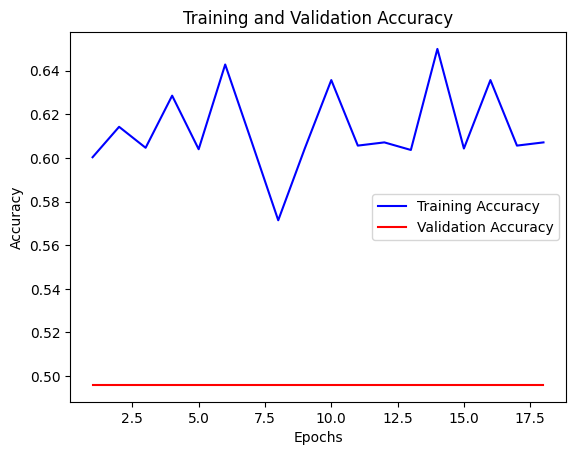

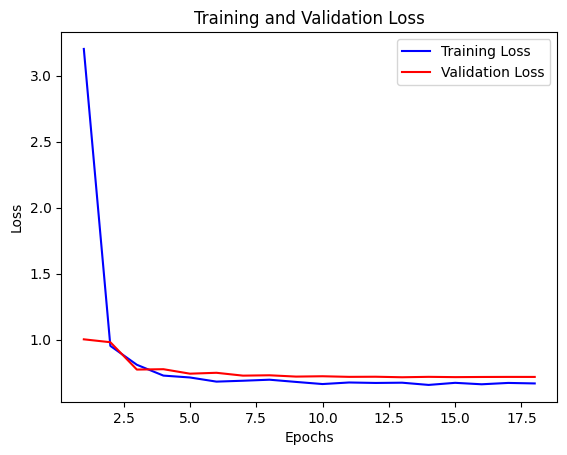

In [54]:
plot_training_history(history)

------------

### **Pretrained network VGG16**

In [3]:
conv_base_VGG16 = VGG16(weights='imagenet', #Charging the pre-trined weights of VGG16 models with  ImageNet dataset
                  include_top=False, #This option indicates that the last layers (fully connected layers) used for final classification don't be imported
                  input_shape=(224, 224, 3)) #This CNN is optimized with a 224x224 resolution

conv_base_VGG16.trainable = False #freezing layers

conv_base_VGG16.summary()

I0000 00:00:1734339664.660381 2214632 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

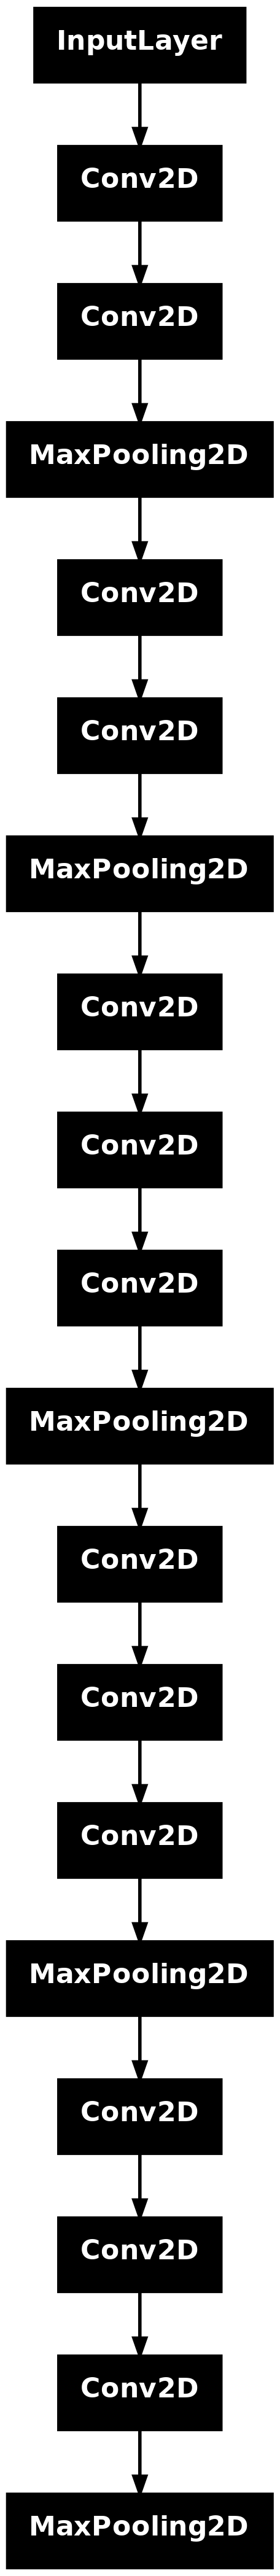

In [19]:
tf.keras.utils.plot_model(conv_base_VGG16)

### *Loading and preprocessing images*

In [6]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size = (224, 224))
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size = (224, 224))
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size = (224, 224))
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [7]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)
'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

### *Fine-tunning*

**Model 1**

In [58]:
model_VGG16_1 = models.Sequential()

# Add pretrained network
model_VGG16_1.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_1.add(layers.Flatten())  # Flatten extracted features
model_VGG16_1.add(layers.Dense(256, activation='relu'))  # Full-connected layer
model_VGG16_1.add(layers.Dropout(0.5))  #To avoid over-fitting
model_VGG16_1.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

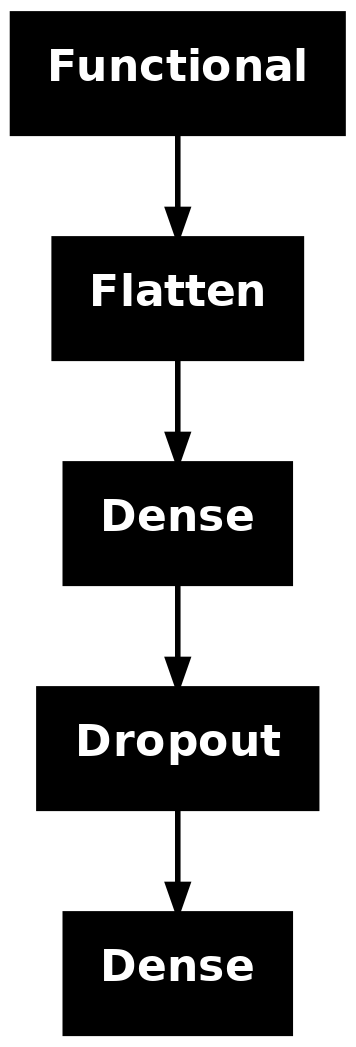

In [6]:
tf.keras.utils.plot_model(model_VGG16_1)

In [59]:
model_VGG16_1.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_VGG16_1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2024-12-04 12:17:52.324014: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 12:17:52.450188: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5538 - loss: 1.2006

2024-12-04 12:18:20.784004: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 12:18:20.851244: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.5540 - loss: 1.1985 - val_accuracy: 0.5789 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5792 - loss: 0.6429

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6263 - loss: 0.6312 - val_accuracy: 0.5203 - val_loss: 0.6958 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.6149 - loss: 0.6551 - val_accuracy: 0.5577 - val_loss: 0.6565 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6453 - loss: 0.6006 - val_accuracy: 0.5756 - val_loss: 0.6522 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.6393 - loss: 0.6241 - val_accuracy: 0.6732 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.6755 - loss: 0.6209

2024-12-04 12:19:21.272038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6648 - loss: 0.6079 - val_accuracy: 0.6829 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.6567 - loss: 0.5989 - val_accuracy: 0.6829 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6647 - loss: 0.6012 - val_accuracy: 0.5967 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.6557 - loss: 0.6014 - val_accuracy: 0.7122 - val_loss: 0.5792 - learning_rate: 0.0010
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.6353 - loss: 0.6135

2024-12-04 12:20:15.526833: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:20:15.526933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6692 - loss: 0.5878 - val_accuracy: 0.6813 - val_loss: 0.6060 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6731 - loss: 0.5531 - val_accuracy: 0.7203 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 12/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7128 - loss: 0.5252 - val_accuracy: 0.6341 - val_loss: 0.6132 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6398 - loss: 0.5707 - val_accuracy: 0.7398 - val_loss: 0.5503 - learning_rate: 0.0010
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.6730 - loss: 0.5562

2024-12-04 12:21:08.176593: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:21:08.176624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6919 - loss: 0.5477 - val_accuracy: 0.7366 - val_loss: 0.5371 - learning_rate: 0.0010
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6800 - loss: 0.5439 - val_accuracy: 0.7220 - val_loss: 0.5766 - learning_rate: 0.0010
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.6197 - loss: 0.6643

2024-12-04 12:21:34.485509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:21:34.485544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6350 - loss: 0.6118 - val_accuracy: 0.6439 - val_loss: 0.5989 - learning_rate: 0.0010
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.6818 - loss: 0.5292 - val_accuracy: 0.7610 - val_loss: 0.5224 - learning_rate: 0.0010
Epoch 18/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.6696 - loss: 0.5334

2024-12-04 12:22:00.963058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:22:00.963090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6441 - loss: 0.5398 - val_accuracy: 0.6764 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6889 - loss: 0.5097 - val_accuracy: 0.7577 - val_loss: 0.5190 - learning_rate: 0.0010
Epoch 20/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7049 - loss: 0.4750 - val_accuracy: 0.7187 - val_loss: 0.5355 - learning_rate: 0.0010
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6915 - loss: 0.5227 - val_accuracy: 0.7447 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 22/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6990 - loss: 0.5506 - val_accuracy: 0.6309 - val_loss: 0.6439 - learning_rate: 0.0010
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.7049 - loss: 0.4958 - val_accuracy: 0.7024 - val_loss: 0.5770 - learning_rate: 0.0010
Epoch 24/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7237 - l

2024-12-04 12:24:00.823604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:24:00.823635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7789 - loss: 0.4875 - val_accuracy: 0.7984 - val_loss: 0.5082 - learning_rate: 0.0010
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7240 - loss: 0.4909 - val_accuracy: 0.7171 - val_loss: 0.5385 - learning_rate: 0.0010
Epoch 28/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7765 - loss: 0.3966 - val_accuracy: 0.7431 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7175 - loss: 0.4632 - val_accuracy: 0.7919 - val_loss: 0.4726 - learning_rate: 0.0010
Epoch 30/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.7082 - loss: 0.4282

2024-12-04 12:24:53.300573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:24:53.300605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7480 - loss: 0.4230 - val_accuracy: 0.7886 - val_loss: 0.4884 - learning_rate: 0.0010
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7369 - loss: 0.4312 - val_accuracy: 0.8179 - val_loss: 0.4418 - learning_rate: 0.0010
Epoch 32/100
  5/150 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.7752 - loss: 0.3509

2024-12-04 12:25:19.692048: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:25:19.692080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7578 - loss: 0.3680 - val_accuracy: 0.7919 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 33/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7405 - loss: 0.4142 - val_accuracy: 0.7398 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 34/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.8025 - loss: 0.3433

2024-12-04 12:25:45.972155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:25:45.972183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8001 - loss: 0.3984 - val_accuracy: 0.7837 - val_loss: 0.4208 - learning_rate: 0.0010
Epoch 35/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7637 - loss: 0.4173 - val_accuracy: 0.7675 - val_loss: 0.5512 - learning_rate: 0.0010
Epoch 36/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6823 - loss: 0.4242 - val_accuracy: 0.8081 - val_loss: 0.4309 - learning_rate: 0.0010
Epoch 37/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7715 - loss: 0.4180 - val_accuracy: 0.7935 - val_loss: 0.4640 - learning_rate: 0.0010
Epoch 38/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7225 - loss: 0.4276 - val_accuracy: 0.7854 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 39/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7760 - loss: 0.3996 - val_accuracy: 0.7528 - val_loss: 0.5524 - learning_rate: 0.0010
Epoch 40/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.8316 -

2024-12-04 12:27:05.332338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7947 - loss: 0.3724 - val_accuracy: 0.7398 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 41/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7695 - loss: 0.4053 - val_accuracy: 0.8309 - val_loss: 0.4446 - learning_rate: 0.0010
Epoch 42/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.8571 - loss: 0.2810

2024-12-04 12:27:31.739406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:27:31.739488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7890 - loss: 0.3520 - val_accuracy: 0.8439 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 43/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.8018 - loss: 0.3641 - val_accuracy: 0.8049 - val_loss: 0.4814 - learning_rate: 0.0010
Epoch 44/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7349 - loss: 0.4233 - val_accuracy: 0.8244 - val_loss: 0.3736 - learning_rate: 0.0010
Epoch 45/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7597 - loss: 0.3989 - val_accuracy: 0.7967 - val_loss: 0.4480 - learning_rate: 0.0010
Epoch 46/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.6182 - loss: 0.4455

2024-12-04 12:28:24.435911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:28:24.435940: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6213 - loss: 0.4464 - val_accuracy: 0.8537 - val_loss: 0.3608 - learning_rate: 0.0010
Epoch 47/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7381 - loss: 0.4028 - val_accuracy: 0.8244 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 48/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.7549 - loss: 0.3409

2024-12-04 12:28:50.933336: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:28:50.933380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7775 - loss: 0.3228 - val_accuracy: 0.8016 - val_loss: 0.4702 - learning_rate: 0.0010
Epoch 49/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7631 - loss: 0.3795 - val_accuracy: 0.8293 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 50/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.8104 - loss: 0.3181

2024-12-04 12:29:17.420651: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:29:17.420688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8413 - loss: 0.3129 - val_accuracy: 0.7756 - val_loss: 0.5612 - learning_rate: 0.0010
Epoch 51/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.8089 - loss: 0.3332 - val_accuracy: 0.8130 - val_loss: 0.4716 - learning_rate: 0.0010
Epoch 52/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8155 - loss: 0.3471 - val_accuracy: 0.8504 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 53/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7780 - loss: 0.3938 - val_accuracy: 0.8407 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 54/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8147 - loss: 0.3404 - val_accuracy: 0.7675 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 55/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7870 - loss: 0.3672 - val_accuracy: 0.7350 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 56/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7369 - l

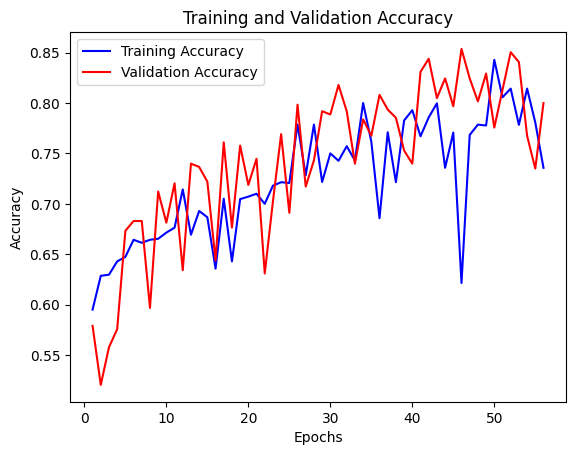

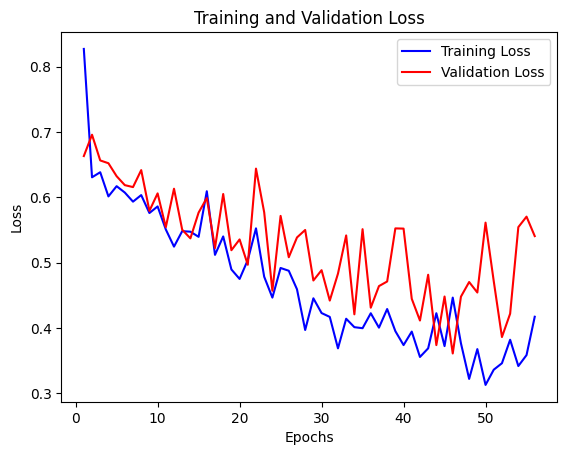

In [61]:
plot_training_history(history)

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2024-12-04 12:33:19.917737: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 12:33:19.993932: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step
Accuracy on test dataset: 0.4967

Classification Report:
               precision    recall  f1-score   support

    fracture       0.50      0.44      0.47       387
  nofracture       0.49      0.55      0.52       380

    accuracy                           0.50       767
   macro avg       0.50      0.50      0.50       767
weighted avg       0.50      0.50      0.50       767



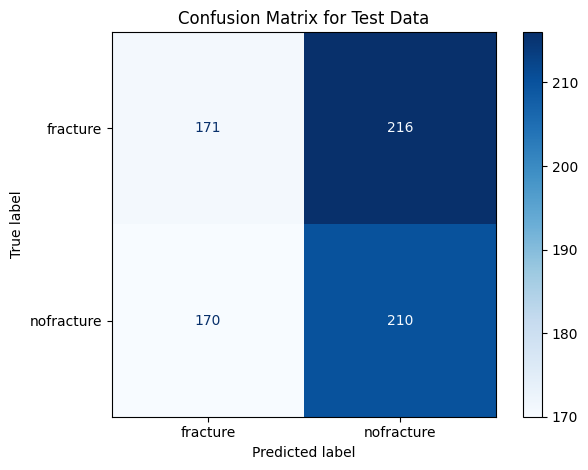

In [62]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
AUC: 0.4843


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


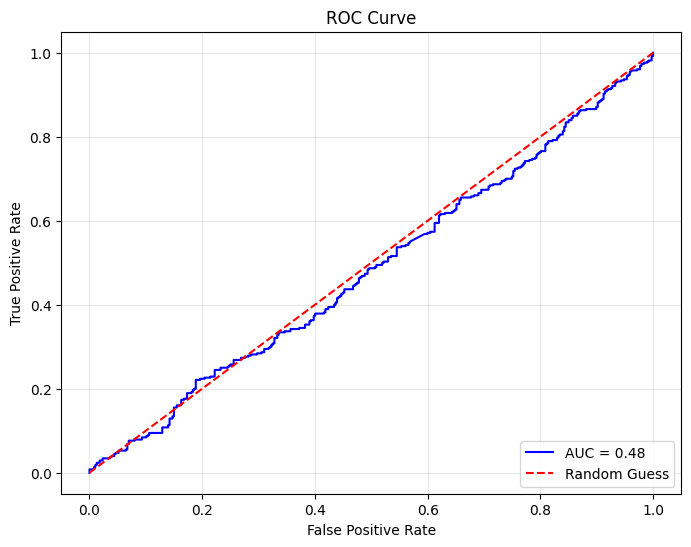

In [63]:
auc = plot_auc_curve(model_VGG16_1, test_ds)

---------------------

**Model 2**

In [64]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [65]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

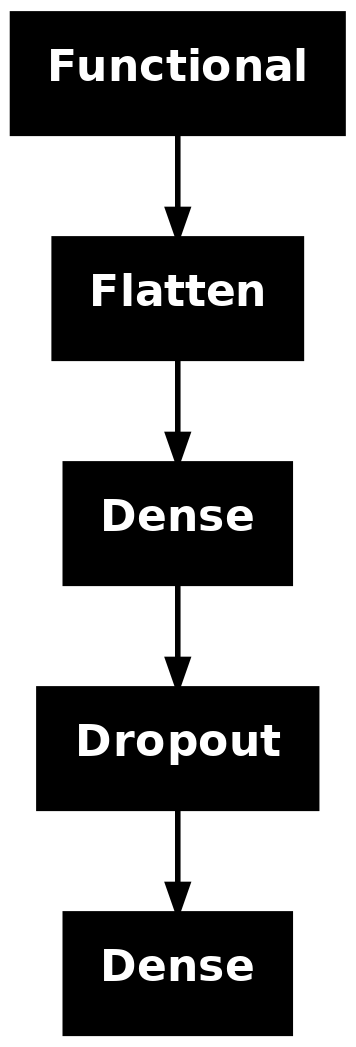

In [26]:
tf.keras.utils.plot_model(model_VGG16_2)

In [66]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2024-12-04 12:34:30.082434: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,28,28]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 12:34:30.488265: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - accuracy: 0.5777 - loss: 5.5067 - val_accuracy: 0.6585 - val_loss: 4.7652 - learning_rate: 1.0000e-05
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - accuracy: 0.6746 - loss: 4.7344

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6443 - loss: 4.7420 - val_accuracy: 0.6715 - val_loss: 4.7162 - learning_rate: 1.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.7220 - loss: 4.4861 - val_accuracy: 0.6829 - val_loss: 4.0635 - learning_rate: 1.0000e-05
Epoch 4/100
  5/150 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.7448 - loss: 3.9624

2024-12-04 12:35:54.209691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:35:54.209734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7706 - loss: 3.9485 - val_accuracy: 0.7772 - val_loss: 3.8990 - learning_rate: 1.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.8187 - loss: 3.7309 - val_accuracy: 0.7301 - val_loss: 3.5352 - learning_rate: 1.0000e-05
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - accuracy: 0.8464 - loss: 3.3389

2024-12-04 12:36:35.445544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:36:35.445600: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8226 - loss: 3.3464 - val_accuracy: 0.8553 - val_loss: 3.3339 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.8665 - loss: 3.1885 - val_accuracy: 0.8520 - val_loss: 2.9773 - learning_rate: 1.0000e-05
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9084 - loss: 2.8834 - val_accuracy: 0.8585 - val_loss: 2.9515 - learning_rate: 1.0000e-05
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9149 - loss: 2.7730 - val_accuracy: 0.7642 - val_loss: 2.9018 - learning_rate: 1.0000e-05
Epoch 10/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 31s 214ms/step - accuracy: 0.8885 - loss: 2.5996

2024-12-04 12:37:57.714253: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:37:57.714291: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8926 - loss: 2.5998 - val_accuracy: 0.8813 - val_loss: 2.6301 - learning_rate: 1.0000e-05
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9348 - loss: 2.4738 - val_accuracy: 0.8179 - val_loss: 2.6277 - learning_rate: 1.0000e-05
Epoch 12/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.9646 - loss: 2.3023

2024-12-04 12:38:39.000630: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:38:39.000678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9642 - loss: 2.2977 - val_accuracy: 0.9073 - val_loss: 2.4090 - learning_rate: 1.0000e-05
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9670 - loss: 2.2158 - val_accuracy: 0.9057 - val_loss: 2.2597 - learning_rate: 1.0000e-05
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9423 - loss: 2.0837 - val_accuracy: 0.8472 - val_loss: 2.4114 - learning_rate: 1.0000e-05
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9711 - loss: 2.0451 - val_accuracy: 0.8537 - val_loss: 2.2920 - learning_rate: 1.0000e-05
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.9610 - loss: 1.9131

2024-12-04 12:40:01.869556: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:40:01.869591: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9641 - loss: 1.9150 - val_accuracy: 0.9024 - val_loss: 2.1157 - learning_rate: 1.0000e-05
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9816 - loss: 1.8828 - val_accuracy: 0.8488 - val_loss: 2.2245 - learning_rate: 1.0000e-05
Epoch 18/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 1.0000 - loss: 1.7745

2024-12-04 12:40:43.014050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:40:43.014082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9931 - loss: 1.7803 - val_accuracy: 0.8943 - val_loss: 2.0755 - learning_rate: 1.0000e-05
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9907 - loss: 1.7511 - val_accuracy: 0.8715 - val_loss: 2.0403 - learning_rate: 1.0000e-05
Epoch 20/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9931 - loss: 1.6565 - val_accuracy: 0.8780 - val_loss: 2.0323 - learning_rate: 1.0000e-05
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9921 - loss: 1.6472 - val_accuracy: 0.8976 - val_loss: 1.9079 - learning_rate: 1.0000e-05
Epoch 22/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 1.0000 - loss: 1.5565

2024-12-04 12:42:06.059791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:42:06.059818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 1.5545 - val_accuracy: 0.8829 - val_loss: 1.9580 - learning_rate: 1.0000e-05
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9925 - loss: 1.5560 - val_accuracy: 0.9057 - val_loss: 1.8057 - learning_rate: 1.0000e-05
Epoch 24/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 1.4848 - val_accuracy: 0.8927 - val_loss: 1.8666 - learning_rate: 1.0000e-05
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9960 - loss: 1.4731 - val_accuracy: 0.9122 - val_loss: 1.6598 - learning_rate: 1.0000e-05
Epoch 26/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 1.0000 - loss: 1.4173

2024-12-04 12:43:28.758116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 1.4174 - val_accuracy: 0.8813 - val_loss: 1.8052 - learning_rate: 1.0000e-05
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9960 - loss: 1.4064 - val_accuracy: 0.9122 - val_loss: 1.6464 - learning_rate: 1.0000e-05
Epoch 28/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9931 - loss: 1.3540 - val_accuracy: 0.8780 - val_loss: 1.7553 - learning_rate: 1.0000e-05
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9915 - loss: 1.3457 - val_accuracy: 0.8878 - val_loss: 1.6417 - learning_rate: 1.0000e-05
Epoch 30/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 1.2822 - val_accuracy: 0.8797 - val_loss: 1.6631 - learning_rate: 1.0000e-05
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9961 - loss: 1.2764 - val_accuracy: 0.9301 - val_loss: 1.4749 - learning_rate: 1.0000e-05
Epoch 32/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/ste

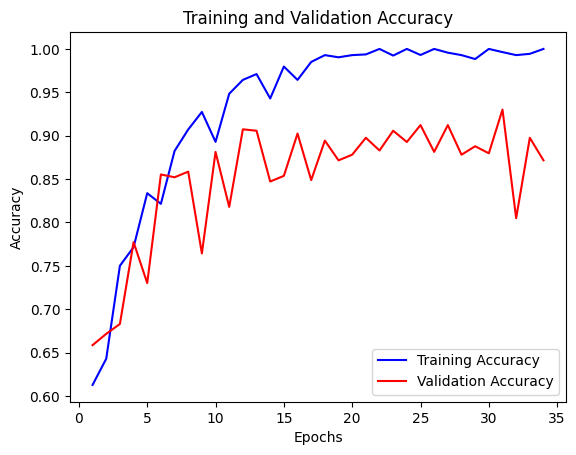

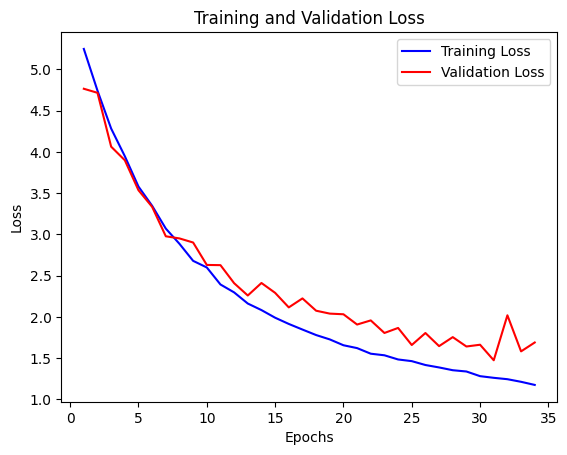

In [68]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step
Accuracy on test dataset: 0.5228

Classification Report:
               precision    recall  f1-score   support

    fracture       0.53      0.47      0.50       387
  nofracture       0.52      0.57      0.54       380

    accuracy                           0.52       767
   macro avg       0.52      0.52      0.52       767
weighted avg       0.52      0.52      0.52       767



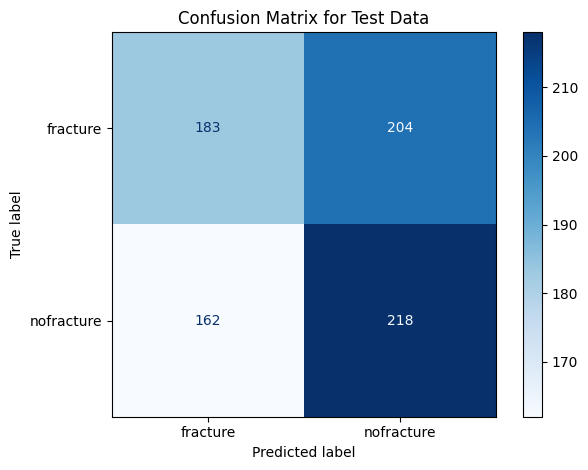

In [69]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_2, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step
AUC: 0.4511


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


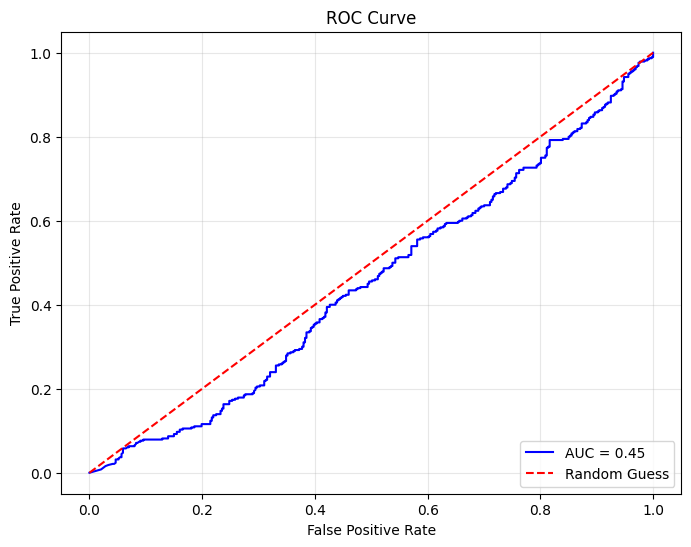

In [70]:
auc = plot_auc_curve(model_VGG16_2, test_ds)

------------------------------

**Model 2.1**

In [71]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [73]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - accuracy: 0.7067 - loss: 5.5817 - val_accuracy: 0.8764 - val_loss: 5.0933 - learning_rate: 1.0000e-05
Epoch 2/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - accuracy: 0.8920 - loss: 5.0419

2024-12-04 12:48:51.341565: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8985 - loss: 5.0285 - val_accuracy: 0.8602 - val_loss: 5.0631 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 243ms/step - accuracy: 0.9250 - loss: 4.8794 - val_accuracy: 0.9024 - val_loss: 4.7713 - learning_rate: 1.0000e-05
Epoch 4/100
 27/130 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.9468 - loss: 4.6295

2024-12-04 12:49:33.271321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:49:33.271350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9493 - loss: 4.6198 - val_accuracy: 0.8862 - val_loss: 4.7637 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.9799 - loss: 4.4901 - val_accuracy: 0.8959 - val_loss: 4.5252 - learning_rate: 1.0000e-05
Epoch 6/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9898 - loss: 4.2969

2024-12-04 12:50:14.299900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9860 - loss: 4.2826 - val_accuracy: 0.8911 - val_loss: 4.5322 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.9857 - loss: 4.2030 - val_accuracy: 0.8959 - val_loss: 4.2857 - learning_rate: 1.0000e-05
Epoch 8/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9944 - loss: 4.0141

2024-12-04 12:50:55.495725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9944 - loss: 4.0051 - val_accuracy: 0.8780 - val_loss: 4.3113 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9873 - loss: 3.9434 - val_accuracy: 0.8894 - val_loss: 4.1490 - learning_rate: 1.0000e-05
Epoch 10/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9951 - loss: 3.7711

2024-12-04 12:51:36.890862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9946 - loss: 3.7623 - val_accuracy: 0.9073 - val_loss: 4.0321 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9900 - loss: 3.7041 - val_accuracy: 0.9057 - val_loss: 3.8206 - learning_rate: 1.0000e-05
Epoch 12/100
 27/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9891 - loss: 3.5632

2024-12-04 12:52:18.325101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9889 - loss: 3.5541 - val_accuracy: 0.9398 - val_loss: 3.6911 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9964 - loss: 3.4802 - val_accuracy: 0.9285 - val_loss: 3.6032 - learning_rate: 1.0000e-05
Epoch 14/100
 23/130 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.9890 - loss: 3.3494

2024-12-04 12:52:59.654071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9889 - loss: 3.3415 - val_accuracy: 0.8683 - val_loss: 3.7610 - learning_rate: 1.0000e-05
Epoch 15/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9781 - loss: 3.3191 - val_accuracy: 0.8894 - val_loss: 3.5717 - learning_rate: 1.0000e-05
Epoch 16/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9962 - loss: 3.1570

2024-12-04 12:53:41.055805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9918 - loss: 3.1547 - val_accuracy: 0.8699 - val_loss: 3.6224 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9976 - loss: 3.0939 - val_accuracy: 0.9122 - val_loss: 3.3449 - learning_rate: 1.0000e-05
Epoch 18/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 2.9717

2024-12-04 12:54:22.467340: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 1.0000 - loss: 2.9647 - val_accuracy: 0.8959 - val_loss: 3.3844 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9979 - loss: 2.9186 - val_accuracy: 0.8911 - val_loss: 3.2520 - learning_rate: 1.0000e-05
Epoch 20/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9994 - loss: 2.8013

2024-12-04 12:55:03.802877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9984 - loss: 2.7967 - val_accuracy: 0.8602 - val_loss: 3.3930 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9982 - loss: 2.7517 - val_accuracy: 0.9122 - val_loss: 3.0190 - learning_rate: 1.0000e-05
Epoch 22/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 2.6441

2024-12-04 12:55:45.196424: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 2.6359 - val_accuracy: 0.9073 - val_loss: 3.0191 - learning_rate: 1.0000e-05
Epoch 23/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9986 - loss: 2.5892 - val_accuracy: 0.8959 - val_loss: 2.9173 - learning_rate: 1.0000e-05
Epoch 24/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 2.4846

2024-12-04 12:56:26.588144: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:56:26.588171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 2.4797 - val_accuracy: 0.9154 - val_loss: 2.8466 - learning_rate: 1.0000e-05
Epoch 25/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9992 - loss: 2.4366 - val_accuracy: 0.8976 - val_loss: 2.8038 - learning_rate: 1.0000e-05
Epoch 26/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9985 - loss: 2.3352 - val_accuracy: 0.8309 - val_loss: 3.1606 - learning_rate: 1.0000e-05
Epoch 27/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9975 - loss: 2.3002 - val_accuracy: 0.9089 - val_loss: 2.5563 - learning_rate: 1.0000e-05
Epoch 28/100
 25/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 2.2006

2024-12-04 12:57:49.323538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9985 - loss: 2.2002 - val_accuracy: 0.9301 - val_loss: 2.4634 - learning_rate: 1.0000e-05
Epoch 29/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9930 - loss: 2.1717 - val_accuracy: 0.8455 - val_loss: 2.4636 - learning_rate: 1.0000e-05
Epoch 30/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9589 - loss: 2.1722

2024-12-04 12:58:30.723848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:58:30.723883: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9728 - loss: 2.1446 - val_accuracy: 0.8667 - val_loss: 2.5118 - learning_rate: 1.0000e-05
Epoch 31/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9912 - loss: 2.0647 - val_accuracy: 0.8911 - val_loss: 2.4206 - learning_rate: 1.0000e-05
Epoch 32/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9950 - loss: 1.9718

2024-12-04 12:59:12.150146: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9961 - loss: 1.9667 - val_accuracy: 0.8992 - val_loss: 2.3611 - learning_rate: 1.0000e-05
Epoch 33/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9954 - loss: 1.9450 - val_accuracy: 0.9089 - val_loss: 2.2695 - learning_rate: 1.0000e-05
Epoch 34/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 1.8679

2024-12-04 12:59:53.581390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:59:53.581418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.8623 - val_accuracy: 0.9057 - val_loss: 2.2570 - learning_rate: 1.0000e-05
Epoch 35/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9998 - loss: 1.8313 - val_accuracy: 0.9024 - val_loss: 2.2037 - learning_rate: 1.0000e-05
Epoch 36/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 1.7650

2024-12-04 13:00:35.023769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:00:35.023802: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.7613 - val_accuracy: 0.9057 - val_loss: 2.2003 - learning_rate: 1.0000e-05
Epoch 37/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9993 - loss: 1.7335 - val_accuracy: 0.9073 - val_loss: 2.0950 - learning_rate: 1.0000e-05
Epoch 38/100
 25/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 1.0000 - loss: 1.6676

2024-12-04 13:01:16.430483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.6641 - val_accuracy: 0.9041 - val_loss: 2.1130 - learning_rate: 1.0000e-05
Epoch 39/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9992 - loss: 1.6363 - val_accuracy: 0.8602 - val_loss: 2.2606 - learning_rate: 1.0000e-05
Epoch 40/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 1.5761

2024-12-04 13:01:57.803581: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9985 - loss: 1.5740 - val_accuracy: 0.8992 - val_loss: 2.0058 - learning_rate: 1.0000e-05
Epoch 41/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9931 - loss: 1.5564 - val_accuracy: 0.8455 - val_loss: 2.2486 - learning_rate: 1.0000e-05
Epoch 42/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9837 - loss: 1.5259

2024-12-04 13:02:39.263254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:02:39.263287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9908 - loss: 1.5153 - val_accuracy: 0.8699 - val_loss: 1.9655 - learning_rate: 1.0000e-05
Epoch 43/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9969 - loss: 1.4687 - val_accuracy: 0.9203 - val_loss: 1.8065 - learning_rate: 1.0000e-05
Epoch 44/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 1.0000 - loss: 1.4048

2024-12-04 13:03:20.744871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.4022 - val_accuracy: 0.9220 - val_loss: 1.7540 - learning_rate: 1.0000e-05
Epoch 45/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9997 - loss: 1.3775 - val_accuracy: 0.9073 - val_loss: 1.7908 - learning_rate: 1.0000e-05
Epoch 46/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 1.3242

2024-12-04 13:04:02.180783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:04:02.180812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.3208 - val_accuracy: 0.9138 - val_loss: 1.7583 - learning_rate: 1.0000e-05
Epoch 47/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9964 - loss: 1.3053 - val_accuracy: 0.8016 - val_loss: 2.3676 - learning_rate: 1.0000e-05


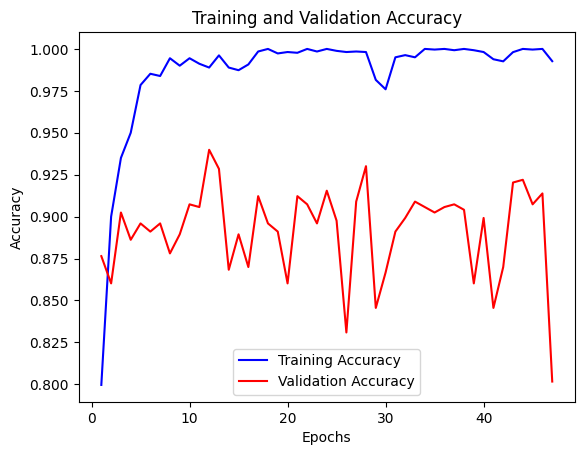

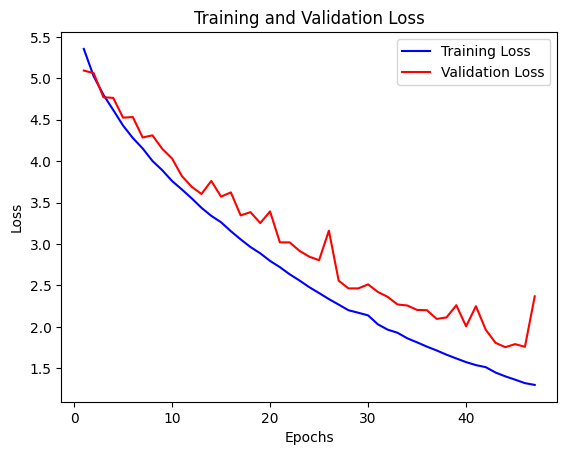

In [75]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step
Accuracy on test dataset: 0.4746

Classification Report:
               precision    recall  f1-score   support

    fracture       0.48      0.41      0.44       387
  nofracture       0.47      0.54      0.51       380

    accuracy                           0.47       767
   macro avg       0.47      0.48      0.47       767
weighted avg       0.47      0.47      0.47       767



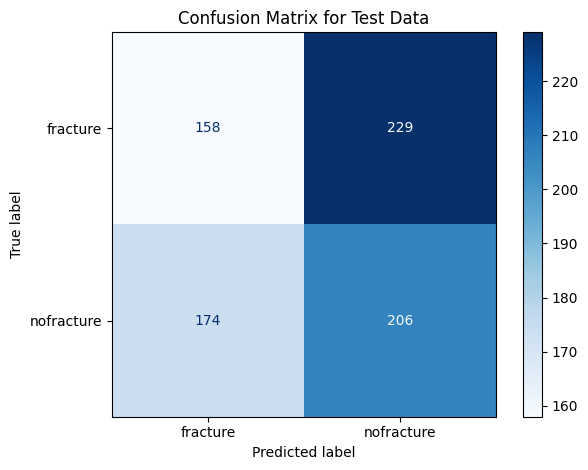

In [76]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_2, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
AUC: 0.4945


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


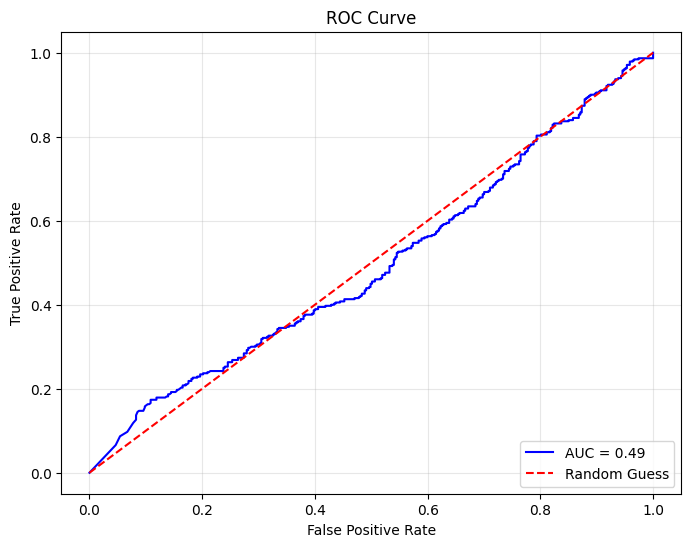

In [77]:
auc = plot_auc_curve(model_VGG16_2, test_ds)

### *Transfer learning*

**Model 3**

In [4]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [8]:
#Extract features
train_features, train_labels = extract_features(conv_base_VGG16, train_ds)
val_features, val_labels = extract_features(conv_base_VGG16, val_ds)
test_features, test_labels = extract_features(conv_base_VGG16, test_ds)

I0000 00:00:1734339764.166417 2247558 service.cc:148] XLA service 0x7f1008004b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734339764.166438 2247558 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-16 10:02:44.174040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734339764.233944 2247558 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-16 10:02:44.522688: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backen

In [9]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

Due to the processing time, the next cell was run aisled the cell and the previous lines associated to the cell (see random_forest_VGG16.py) an run in a remote server using ssh connection. To run the code, I used:

nohup python3 random_forest_VGG16.py 

The result is saved in a file called nohup.out

In [ ]:
#Training the Machine Learning Model

params = [{
    "n_estimators": [100, 500, 1000, 1500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(1, 100),
    "min_samples_split": range(100, 501)
}]

#Random forest
random_forest = RandomizedSearchCV(RandomForestClassifier(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
random_forest.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(random_forest.best_estimator_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


Best estimator found by random search:
RandomForestClassifier(max_depth=70, min_samples_split=102, n_estimators=1500)

In [11]:
random_forest = RandomForestClassifier(max_depth=70, min_samples_split=102, n_estimators=1500)
random_forest.fit(train_features, np.ravel(train_labels))

RandomForestClassifier(max_depth=70, min_samples_split=102, n_estimators=1500)

Accuracy in test: 0.636245110821382
              precision    recall  f1-score   support

         0.0       0.99      0.28      0.44       387
         1.0       0.58      1.00      0.73       380

    accuracy                           0.64       767
   macro avg       0.78      0.64      0.58       767
weighted avg       0.79      0.64      0.58       767



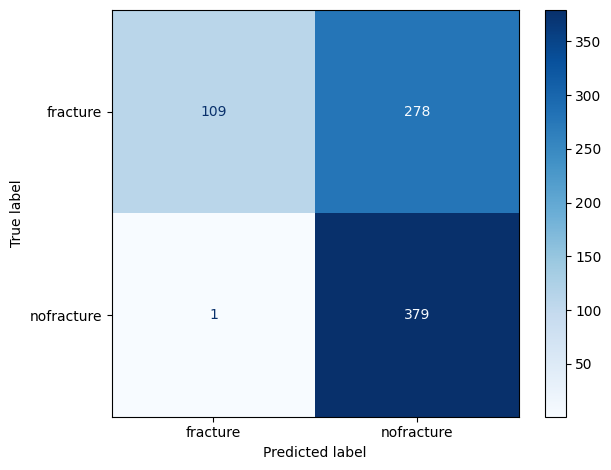

In [13]:
#Evaluating the model
test_predictions = random_forest.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.9423


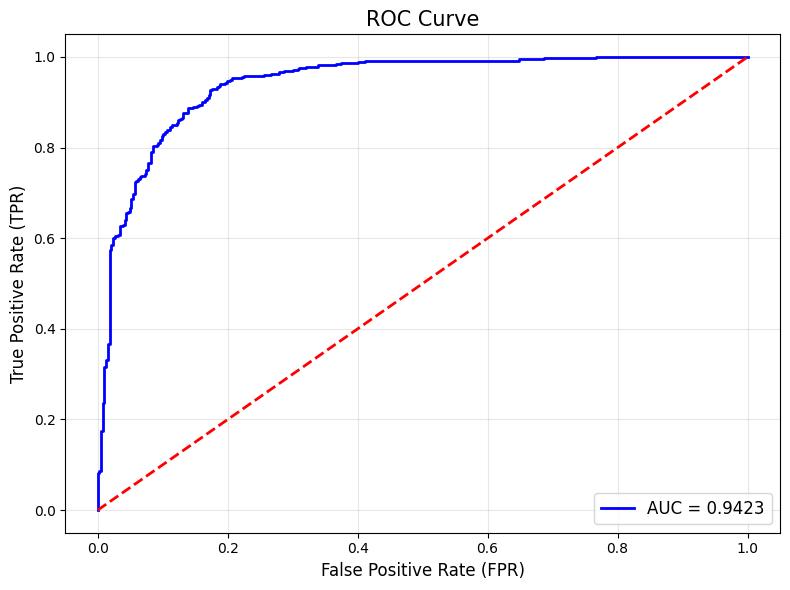

In [14]:
#Obtaining probability for positive class (1)
test_probabilities = random_forest.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Due to the processing time, the next cell was run aisled the cell and the previous lines associated to the cell (see svc_VGG16.py) an run in a remote server using ssh connection. To run the code, I used:

nohup python3 svc_VGG16.py 

The result is saved in a file called nohup.out

In [ ]:
params =[{
    "C":[0.1, 1, 10, 100, 1000],
    "kernel":["linear", "poly", "rbf", "sigmoid"],
    "degree":[1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "shrinking":[True, False],
    "tol": [1e-1, 1e-2, 1e-3],
    "class_weight":["dict", "balance", None],
    "decision_function_shape":["ovo", "ovr"]     
}] 

#Random forest
svc = RandomizedSearchCV(SVC(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
svc.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(svc.best_estimator_)

Best estimator found by random search:
SVC(C=10, degree=5, kernel='poly', tol=0.01)

In [13]:
svc = SVC(C=10, degree=5, kernel='poly', tol=0.01, probability=True)
svc.fit(train_features, np.ravel(train_labels))

SVC(C=10, degree=5, kernel='poly', probability=True, tol=0.01)

Accuracy in test: 0.8578878748370273
              precision    recall  f1-score   support

         0.0       0.99      0.73      0.84       387
         1.0       0.78      0.99      0.87       380

    accuracy                           0.86       767
   macro avg       0.88      0.86      0.86       767
weighted avg       0.89      0.86      0.86       767



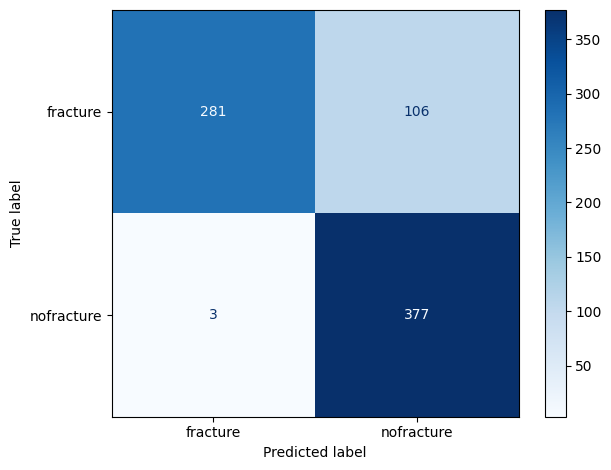

In [14]:
#Evaluating the model
test_predictions = svc.predict(test_features)
print("Accuracy in test:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.9727


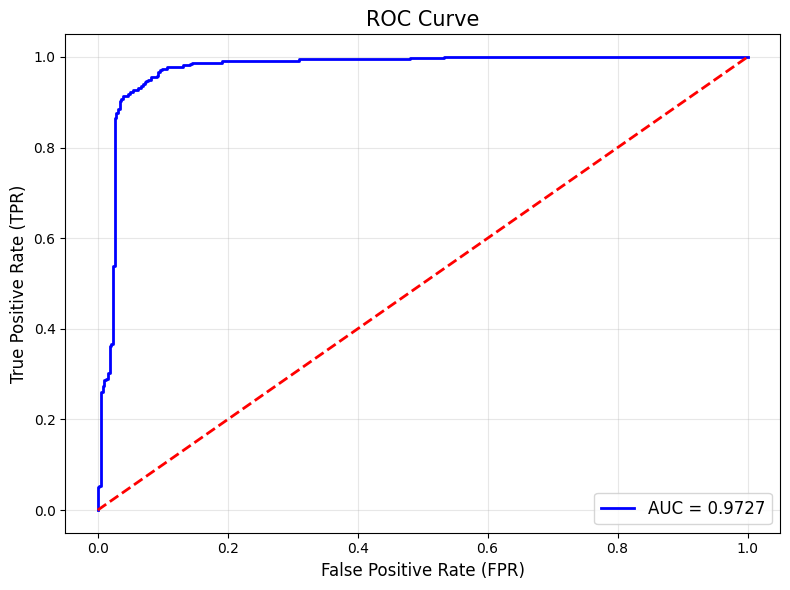

In [15]:
#Obtaining probability for positive class (1)
test_probabilities = svc.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

-----------------

### **Pretrained network ResNet-50**

In [5]:
#Load ResNet
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the layers
resnet_base.trainable = False

resnet_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

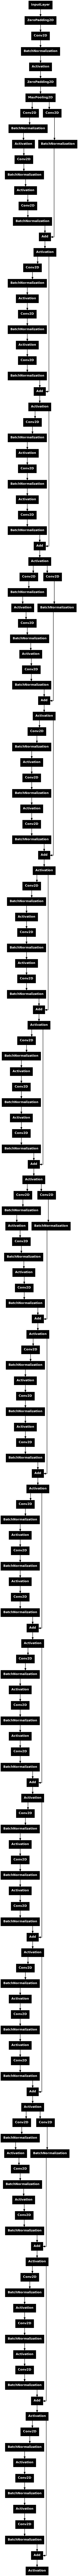

In [8]:
tf.keras.utils.plot_model(resnet_base)

### *Loading and preprocesing images*

In [6]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [7]:
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255)

### *Fine-tunning*

**Model 1**

In [7]:
model_resnet_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_1.add(resnet_base)

# Add personalized layers
model_resnet_1.add(layers.Flatten())  # Flatten extracted features
model_resnet_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_1.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_1.add(layers.Dense(1, activation='sigmoid'))

model_resnet_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

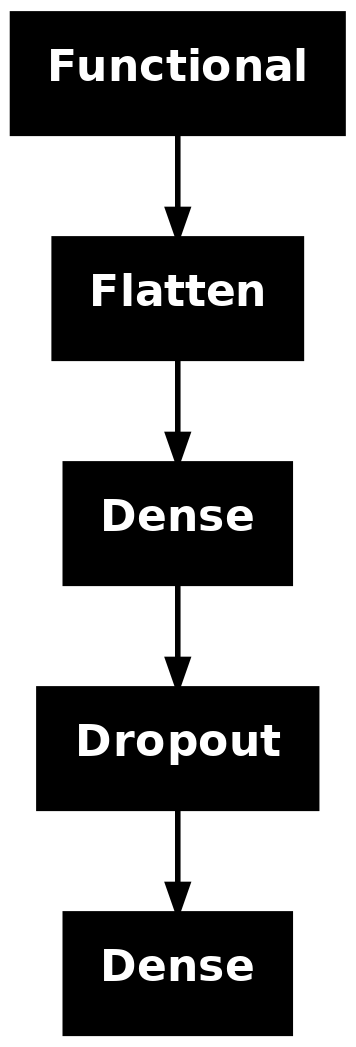

In [10]:
tf.keras.utils.plot_model(model_resnet_1)

In [8]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_resnet_1, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


I0000 00:00:1734344800.850106 3601897 service.cc:148] XLA service 0x7fcf4c04df20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734344800.850535 3601897 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-16 11:26:41.475392: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734344802.470384 3601897 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-16 11:26:43.490887: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_

  1/130 ━━━━━━━━━━━━━━━━━━━━ 24:18 11s/step - accuracy: 0.4062 - loss: 5.8587

I0000 00:00:1734344807.031580 3601897 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5135 - loss: 5.4198

2024-12-16 11:26:55.850335: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[4,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-16 11:26:56.030506: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[4,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivati

 99/130 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5138 - loss: 5.4155

2024-12-16 11:26:58.212381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-16 11:26:58.212592: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-16 11:27:03.539935: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x

130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - accuracy: 0.5199 - loss: 5.3155 - val_accuracy: 0.4959 - val_loss: 4.2019 - learning_rate: 1.0000e-05
Epoch 2/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5611 - loss: 3.8858

2024-12-16 11:27:13.710119: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5656 - loss: 3.8164 - val_accuracy: 0.4959 - val_loss: 3.1162 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5879 - loss: 2.7883 - val_accuracy: 0.4959 - val_loss: 2.3417 - learning_rate: 1.0000e-05
Epoch 4/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5737 - loss: 2.1306

2024-12-16 11:27:32.716221: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5784 - loss: 2.0955 - val_accuracy: 0.4959 - val_loss: 1.8101 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5976 - loss: 1.6129 - val_accuracy: 0.4959 - val_loss: 1.4444 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5949 - loss: 1.3117 - val_accuracy: 0.4959 - val_loss: 1.1809 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5961 - loss: 1.0983 - val_accuracy: 0.4959 - val_loss: 1.0455 - learning_rate: 1.0000e-05
Epoch 8/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5990 - loss: 0.9713

2024-12-16 11:28:10.898876: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6007 - loss: 0.9654 - val_accuracy: 0.4959 - val_loss: 0.9482 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5940 - loss: 0.8891 - val_accuracy: 0.4959 - val_loss: 0.8859 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6005 - loss: 0.8366 - val_accuracy: 0.4959 - val_loss: 0.8523 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6024 - loss: 0.8056 - val_accuracy: 0.4959 - val_loss: 0.8350 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5972 - loss: 0.7913 - val_accuracy: 0.4959 - val_loss: 0.8206 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5979 - loss: 0.7807 - val_accuracy: 0.4959 - val_loss: 0.8227 - learning_rate: 1.0000e-05
Epoch 14/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step 

2024-12-16 11:29:27.319858: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5998 - loss: 0.7676 - val_accuracy: 0.4959 - val_loss: 0.7985 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5951 - loss: 0.7645 - val_accuracy: 0.4959 - val_loss: 0.7994 - learning_rate: 1.0000e-05
Epoch 18/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5996 - loss: 0.7614 - val_accuracy: 0.4959 - val_loss: 0.7957 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5967 - loss: 0.7608 - val_accuracy: 0.4959 - val_loss: 0.7954 - learning_rate: 1.0000e-05
Epoch 20/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5970 - loss: 0.7587 - val_accuracy: 0.4959 - val_loss: 0.7941 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5994 - loss: 0.7560 - val_accuracy: 0.4959 - val_loss: 0.7928 - learning_rate: 1.0000e-05
Epoch 22/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step 

2024-12-16 11:32:00.967303: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.6012 - loss: 0.7338 - val_accuracy: 0.4959 - val_loss: 0.7771 - learning_rate: 1.0000e-05
Epoch 33/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5974 - loss: 0.7326 - val_accuracy: 0.4959 - val_loss: 0.7752 - learning_rate: 1.0000e-05
Epoch 34/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5914 - loss: 0.7352 - val_accuracy: 0.4959 - val_loss: 0.7684 - learning_rate: 1.0000e-05
Epoch 35/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5950 - loss: 0.7328 - val_accuracy: 0.4959 - val_loss: 0.7724 - learning_rate: 1.0000e-05
Epoch 36/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5990 - loss: 0.7286 - val_accuracy: 0.4959 - val_loss: 0.7682 - learning_rate: 1.0000e-05
Epoch 37/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5974 - loss: 0.7284 - val_accuracy: 0.4959 - val_loss: 0.7663 - learning_rate: 1.0000e-05
Epoch 38/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/ste

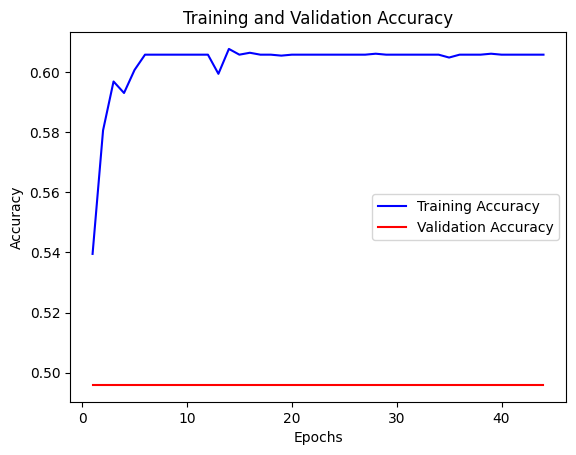

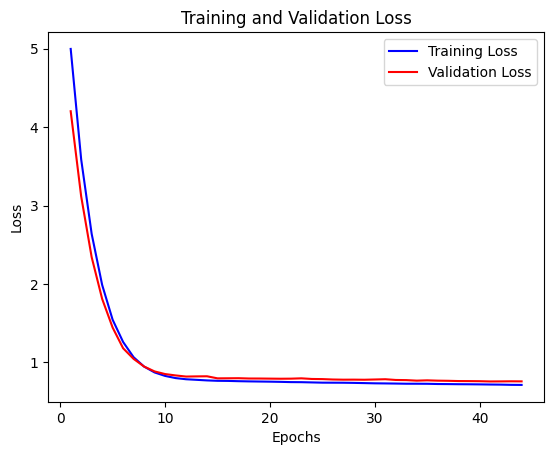

In [10]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

**Model 2**

In [11]:
model_resnet_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_2.add(resnet_base)

# Add personalized layers
model_resnet_2.add(layers.GlobalAveragePooling2D())
model_resnet_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_2.add(layers.Dense(1, activation='sigmoid'))

model_resnet_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

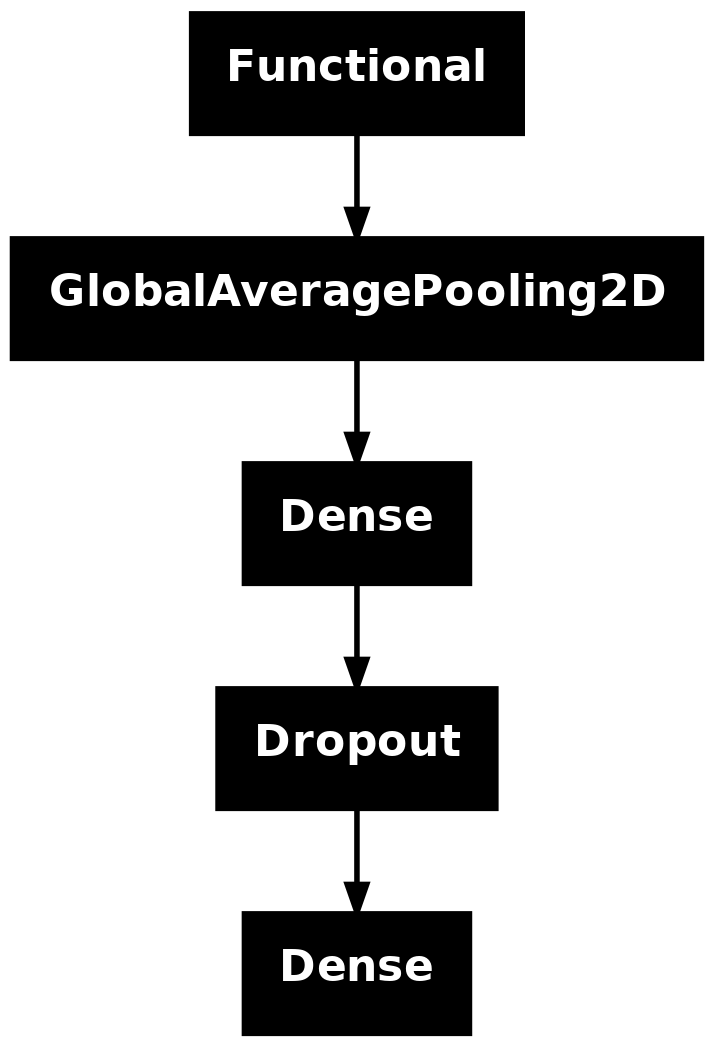

In [38]:
tf.keras.utils.plot_model(model_resnet_2)

In [12]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 

history = train_model(model_resnet_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.5775 - loss: 5.1860 - val_accuracy: 0.4959 - val_loss: 5.0201 - learning_rate: 1.0000e-05
Epoch 2/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5336 - loss: 4.9606

2024-12-16 11:35:21.687358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5388 - loss: 4.9428 - val_accuracy: 0.4959 - val_loss: 4.7896 - learning_rate: 1.0000e-05
Epoch 3/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5764 - loss: 4.7110

2024-12-16 11:35:30.611792: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401
2024-12-16 11:35:30.611875: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4442758681475272302


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5738 - loss: 4.6981 - val_accuracy: 0.4959 - val_loss: 4.5649 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5743 - loss: 4.4818 - val_accuracy: 0.4959 - val_loss: 4.3515 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5570 - loss: 4.2798 - val_accuracy: 0.4959 - val_loss: 4.1571 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5503 - loss: 4.0843 - val_accuracy: 0.4959 - val_loss: 3.9656 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5637 - loss: 3.8919 - val_accuracy: 0.4959 - val_loss: 3.7893 - learning_rate: 1.0000e-05
Epoch 8/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5546 - loss: 3.7229

2024-12-16 11:36:15.724422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5580 - loss: 3.7107 - val_accuracy: 0.4959 - val_loss: 3.6177 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5590 - loss: 3.5485 - val_accuracy: 0.4959 - val_loss: 3.4561 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5672 - loss: 3.3843 - val_accuracy: 0.4959 - val_loss: 3.2988 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5592 - loss: 3.2382 - val_accuracy: 0.4959 - val_loss: 3.1566 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5589 - loss: 3.0908 - val_accuracy: 0.4959 - val_loss: 3.0167 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5711 - loss: 2.9510 - val_accuracy: 0.4959 - val_loss: 2.8847 - learning_rate: 1.0000e-05
Epoch 14/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - acc

2024-12-16 11:38:04.147140: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5782 - loss: 2.1740 - val_accuracy: 0.4959 - val_loss: 2.1361 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5558 - loss: 2.0865 - val_accuracy: 0.4959 - val_loss: 2.0489 - learning_rate: 1.0000e-05
Epoch 22/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5762 - loss: 1.9912 - val_accuracy: 0.4959 - val_loss: 1.9673 - learning_rate: 1.0000e-05
Epoch 23/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5807 - loss: 1.9073 - val_accuracy: 0.4959 - val_loss: 1.8897 - learning_rate: 1.0000e-05
Epoch 24/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5743 - loss: 1.8378 - val_accuracy: 0.4959 - val_loss: 1.8180 - learning_rate: 1.0000e-05
Epoch 25/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5814 - loss: 1.7633

2024-12-16 11:38:49.489156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5832 - loss: 1.7590 - val_accuracy: 0.4959 - val_loss: 1.7483 - learning_rate: 1.0000e-05
Epoch 26/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5716 - loss: 1.6972 - val_accuracy: 0.4959 - val_loss: 1.6821 - learning_rate: 1.0000e-05
Epoch 27/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5634 - loss: 1.6319 - val_accuracy: 0.4959 - val_loss: 1.6190 - learning_rate: 1.0000e-05
Epoch 28/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5742 - loss: 1.5721 - val_accuracy: 0.4959 - val_loss: 1.5616 - learning_rate: 1.0000e-05
Epoch 29/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5685 - loss: 1.5089 - val_accuracy: 0.4959 - val_loss: 1.5087 - learning_rate: 1.0000e-05
Epoch 30/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5806 - loss: 1.4581 - val_accuracy: 0.4959 - val_loss: 1.4558 - learning_rate: 1.0000e-05
Epoch 31/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - ac

2024-12-16 11:41:05.660807: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401
2024-12-16 11:41:05.660841: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4442758681475272302


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5926 - loss: 1.0653 - val_accuracy: 0.4959 - val_loss: 1.0867 - learning_rate: 1.0000e-05
Epoch 41/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5833 - loss: 1.0411 - val_accuracy: 0.4959 - val_loss: 1.0630 - learning_rate: 1.0000e-05
Epoch 42/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5786 - loss: 1.0224 - val_accuracy: 0.4959 - val_loss: 1.0439 - learning_rate: 1.0000e-05
Epoch 43/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5861 - loss: 1.0040 - val_accuracy: 0.4959 - val_loss: 1.0212 - learning_rate: 1.0000e-05
Epoch 44/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5868 - loss: 0.9766 - val_accuracy: 0.4959 - val_loss: 1.0041 - learning_rate: 1.0000e-05
Epoch 45/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5933 - loss: 0.9547 - val_accuracy: 0.4959 - val_loss: 0.9839 - learning_rate: 1.0000e-05
Epoch 46/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - ac

2024-12-16 11:42:54.566095: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5876 - loss: 0.8653 - val_accuracy: 0.4959 - val_loss: 0.8909 - learning_rate: 1.0000e-05
Epoch 53/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5854 - loss: 0.8522 - val_accuracy: 0.4959 - val_loss: 0.8836 - learning_rate: 1.0000e-05
Epoch 54/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5913 - loss: 0.8425 - val_accuracy: 0.4959 - val_loss: 0.8754 - learning_rate: 1.0000e-05
Epoch 55/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5918 - loss: 0.8324 - val_accuracy: 0.4959 - val_loss: 0.8714 - learning_rate: 1.0000e-05
Epoch 56/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5841 - loss: 0.8331

2024-12-16 11:43:30.906223: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401
2024-12-16 11:43:30.906250: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4442758681475272302


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5894 - loss: 0.8306 - val_accuracy: 0.4959 - val_loss: 0.8620 - learning_rate: 1.0000e-05
Epoch 57/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5950 - loss: 0.8208 - val_accuracy: 0.4959 - val_loss: 0.8551 - learning_rate: 1.0000e-05
Epoch 58/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5900 - loss: 0.8179 - val_accuracy: 0.4959 - val_loss: 0.8519 - learning_rate: 1.0000e-05
Epoch 59/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5904 - loss: 0.8067

2024-12-16 11:43:59.287903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5935 - loss: 0.8056 - val_accuracy: 0.4959 - val_loss: 0.8458 - learning_rate: 1.0000e-05
Epoch 60/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5874 - loss: 0.8060 - val_accuracy: 0.4959 - val_loss: 0.8419 - learning_rate: 1.0000e-05
Epoch 61/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5930 - loss: 0.8020 - val_accuracy: 0.4959 - val_loss: 0.8380 - learning_rate: 1.0000e-05
Epoch 62/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5949 - loss: 0.7979 - val_accuracy: 0.4959 - val_loss: 0.8342 - learning_rate: 1.0000e-05
Epoch 63/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5926 - loss: 0.7929 - val_accuracy: 0.4959 - val_loss: 0.8308 - learning_rate: 1.0000e-05
Epoch 64/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5971 - loss: 0.7915 - val_accuracy: 0.4959 - val_loss: 0.8296 - learning_rate: 1.0000e-05
Epoch 65/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - ac

2024-12-16 11:45:02.966937: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5985 - loss: 0.7856 - val_accuracy: 0.4959 - val_loss: 0.8270 - learning_rate: 1.0000e-05
Epoch 67/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5891 - loss: 0.7824 - val_accuracy: 0.4959 - val_loss: 0.8221 - learning_rate: 1.0000e-05
Epoch 68/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5907 - loss: 0.7831 - val_accuracy: 0.4959 - val_loss: 0.8214 - learning_rate: 1.0000e-05
Epoch 69/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5908 - loss: 0.7782

2024-12-16 11:45:30.194140: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401
2024-12-16 11:45:30.194169: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4442758681475272302


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5937 - loss: 0.7772 - val_accuracy: 0.4959 - val_loss: 0.8188 - learning_rate: 1.0000e-05
Epoch 70/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5902 - loss: 0.7794 - val_accuracy: 0.4959 - val_loss: 0.8126 - learning_rate: 1.0000e-05
Epoch 71/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5902 - loss: 0.7769 - val_accuracy: 0.4959 - val_loss: 0.8164 - learning_rate: 1.0000e-05
Epoch 72/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5889 - loss: 0.7765 - val_accuracy: 0.4959 - val_loss: 0.8119 - learning_rate: 1.0000e-05
Epoch 73/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5926 - loss: 0.7749 - val_accuracy: 0.4959 - val_loss: 0.8120 - learning_rate: 1.0000e-05
Epoch 74/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5939 - loss: 0.7710 - val_accuracy: 0.4959 - val_loss: 0.8100 - learning_rate: 1.0000e-05
Epoch 75/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - ac

2024-12-16 11:47:46.724758: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5928 - loss: 0.7603 - val_accuracy: 0.4959 - val_loss: 0.8021 - learning_rate: 1.0000e-05
Epoch 85/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5944 - loss: 0.7587 - val_accuracy: 0.4959 - val_loss: 0.7988 - learning_rate: 1.0000e-05
Epoch 86/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5971 - loss: 0.7588 - val_accuracy: 0.4959 - val_loss: 0.8007 - learning_rate: 1.0000e-05
Epoch 87/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5977 - loss: 0.7568 - val_accuracy: 0.4959 - val_loss: 0.7977 - learning_rate: 1.0000e-05
Epoch 88/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5972 - loss: 0.7555 - val_accuracy: 0.4959 - val_loss: 0.7979 - learning_rate: 1.0000e-05
Epoch 89/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5960 - loss: 0.7583 - val_accuracy: 0.4959 - val_loss: 0.7950 - learning_rate: 1.0000e-05
Epoch 90/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - ac

2024-12-16 11:49:45.530394: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15400111378278212401


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5961 - loss: 0.7499 - val_accuracy: 0.4959 - val_loss: 0.7934 - learning_rate: 1.0000e-05
Epoch 98/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5892 - loss: 0.7516 - val_accuracy: 0.4959 - val_loss: 0.7919 - learning_rate: 5.0000e-06
Epoch 99/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.6002 - loss: 0.7457 - val_accuracy: 0.4959 - val_loss: 0.7915 - learning_rate: 5.0000e-06
Epoch 100/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5979 - loss: 0.7459 - val_accuracy: 0.4959 - val_loss: 0.7896 - learning_rate: 5.0000e-06


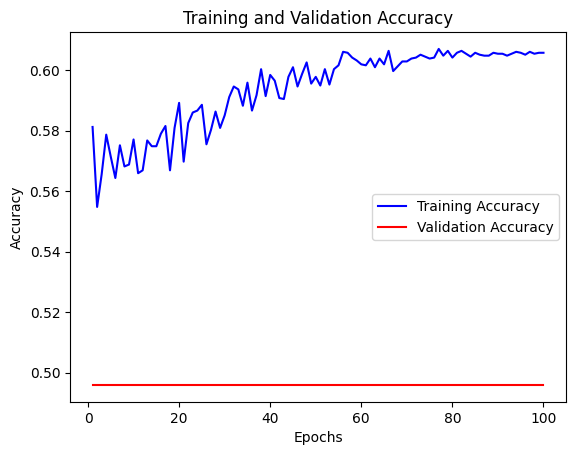

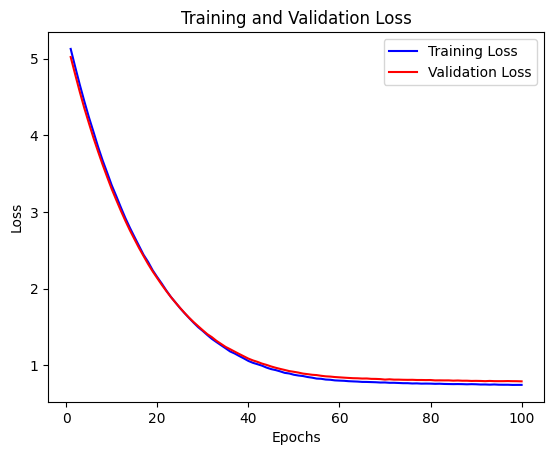

In [14]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

--------------------------

### *Transfer learning*

**Model 3**

In [8]:
#Unfreezing the lats 8 layers
for layer in resnet_base.layers[50:]:
    layer.trainable = True

In [9]:
#Extract features
train_features, train_labels = extract_features(resnet_base, train_ds)
val_features, val_labels = extract_features(resnet_base, val_ds)
test_features, test_labels = extract_features(resnet_base, test_ds)

I0000 00:00:1737444005.163628 1730927 service.cc:148] XLA service 0x7fd198048560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737444005.163899 1730927 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-01-21 08:20:05.270021: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737444005.711521 1730927 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-21 08:20:06.720690: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_

In [10]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

Due to the processing time, the next cell was run aisled the cell and the previous lines associated to the cell (see random_forest_resnet50.py) an run in a remote server using ssh connection. To run the code, I used:

nohup python3 random_forest_resnet50.py 

The result is saved in a file called nohup.out

In [ ]:
#Training the Machine Learning Model

#Random forest
params = [{
    "n_estimators": [100, 500, 1000, 1500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": range(1, 100),
    "min_samples_split": range(100, 501)
}]

#Random forest
random_forest = RandomizedSearchCV(RandomForestClassifier(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
random_forest.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(random_forest.best_estimator_)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

Best estimator found by random search:
RandomForestClassifier(criterion='entropy', max_depth=49, min_samples_split=102)

In [39]:
random_forest = RandomForestClassifier(criterion='entropy', max_depth=49, min_samples_split=102)
random_forest.fit(train_features, np.ravel(train_labels))

RandomForestClassifier(criterion='entropy', max_depth=49, min_samples_split=102)

Accuracy en validación: 0.559322033898305
              precision    recall  f1-score   support

         0.0       0.96      0.13      0.23       387
         1.0       0.53      0.99      0.69       380

    accuracy                           0.56       767
   macro avg       0.75      0.56      0.46       767
weighted avg       0.75      0.56      0.46       767



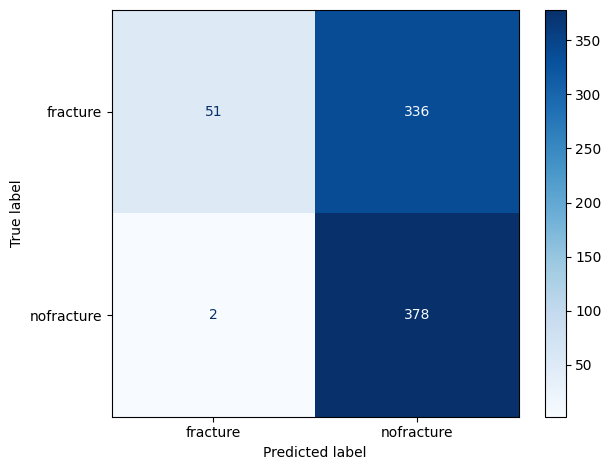

In [40]:
#Evaluating the model
test_predictions = random_forest.predict(test_features)
print("Accuracy en validación:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

AUC: 0.8731


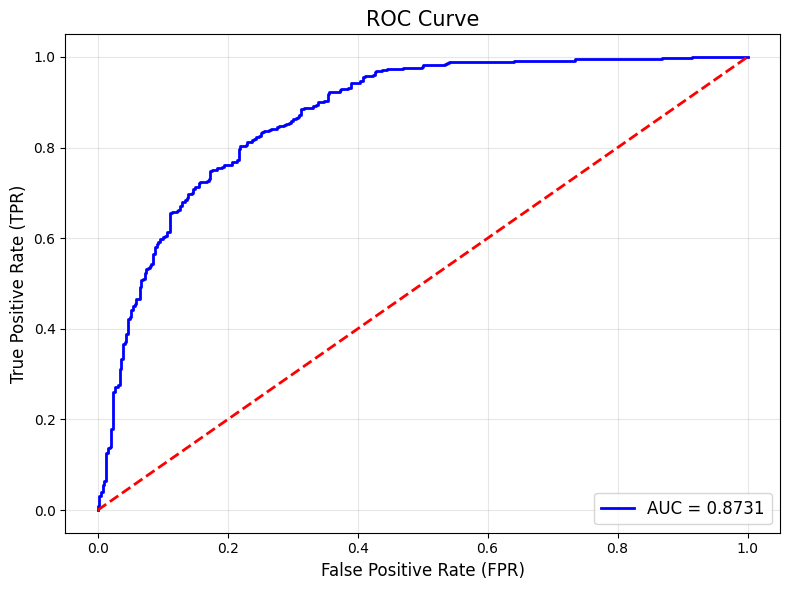

In [41]:
#Obtaining probability for positive class (1)
test_probabilities = random_forest.predict_proba(test_features)[:, 1]

# Calculating FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(test_labels, test_probabilities)

# Calculaing the area under the curve (AUC)
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC: {auc:.4f}")

#Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2)  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---

Due to the processing time, this part of the code was nor runned

params = [{
    "C": [10, 100, 1000],
    "kernel": ["linear", "rbf"],  # Reduced kernels
    "gamma": ["scale", "auto"],
    "shrinking": [True, False],
    "tol": [1e-1, 1e-3],  # Focused tolerance
    "class_weight": [None, "balanced"],
    "decision_function_shape": ["ovo", "ovr"]
}]

#Random forest
svc = RandomizedSearchCV(SVC(), params, cv = 5, n_iter = 1000, verbose = 1, random_state=42, n_jobs = 6)
svc.fit(train_features, np.ravel(train_labels))

print("")
print("Best estimator found by random search:")
print(svc.best_estimator_)

In [11]:
#This was the best SVC model for VGG16
svc = SVC(C=10, degree=5, kernel='poly', tol=0.01, probability=True)
svc.fit(train_features, np.ravel(train_labels))

SVC(C=10, degree=5, kernel='poly', probability=True, tol=0.01)

Accuracy en validación: 0.5110821382007823
              precision    recall  f1-score   support

         0.0       0.88      0.04      0.07       387
         1.0       0.50      0.99      0.67       380

    accuracy                           0.51       767
   macro avg       0.69      0.52      0.37       767
weighted avg       0.69      0.51      0.37       767



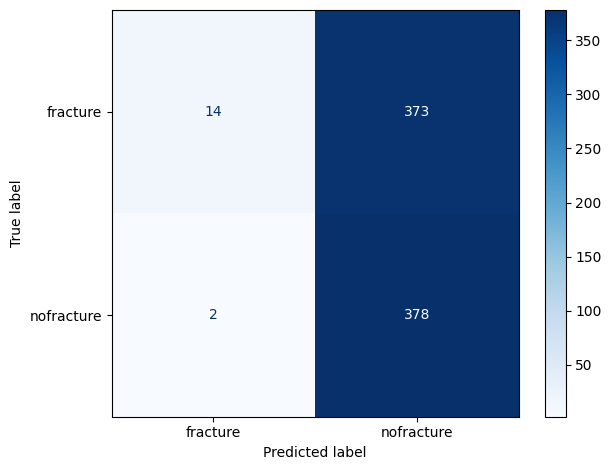

In [13]:
#Evaluating the model
test_predictions = svc.predict(test_features)
print("Accuracy en validación:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

---------------------

### **Pretrained network MobileNetV3**

In [16]:
#Load MobilNetV3
mobilenet_base = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the layers
mobilenet_base.trainable = False

mobilenet_base.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [25]:
tf.keras.utils.plot_model(mobilenet_base, show_shapes=True)

### *Loading and preprocesing images*

In [26]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [27]:
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255)

### *Fine-tunning*

**Model 1**

In [29]:
model_mobilenet_1 = models.Sequential()
# Add pretrained networkAñadir la base preentrenada
model_mobilenet_1.add(mobilenet_base)

# Add personalized layers
model_mobilenet_1.add(layers.Flatten())  # Flatten extracted features
model_mobilenet_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_mobilenet_1.add(layers.Dropout(0.3))  #To avoid over-fitting
model_mobilenet_1.add(layers.Dense(1, activation='sigmoid'))

model_mobilenet_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,225,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,164,977 (31.15 MB)

 Trainable params: 7,225,857 (27.56 MB)

 Non-trainable params: 939,120 (3.58 MB)

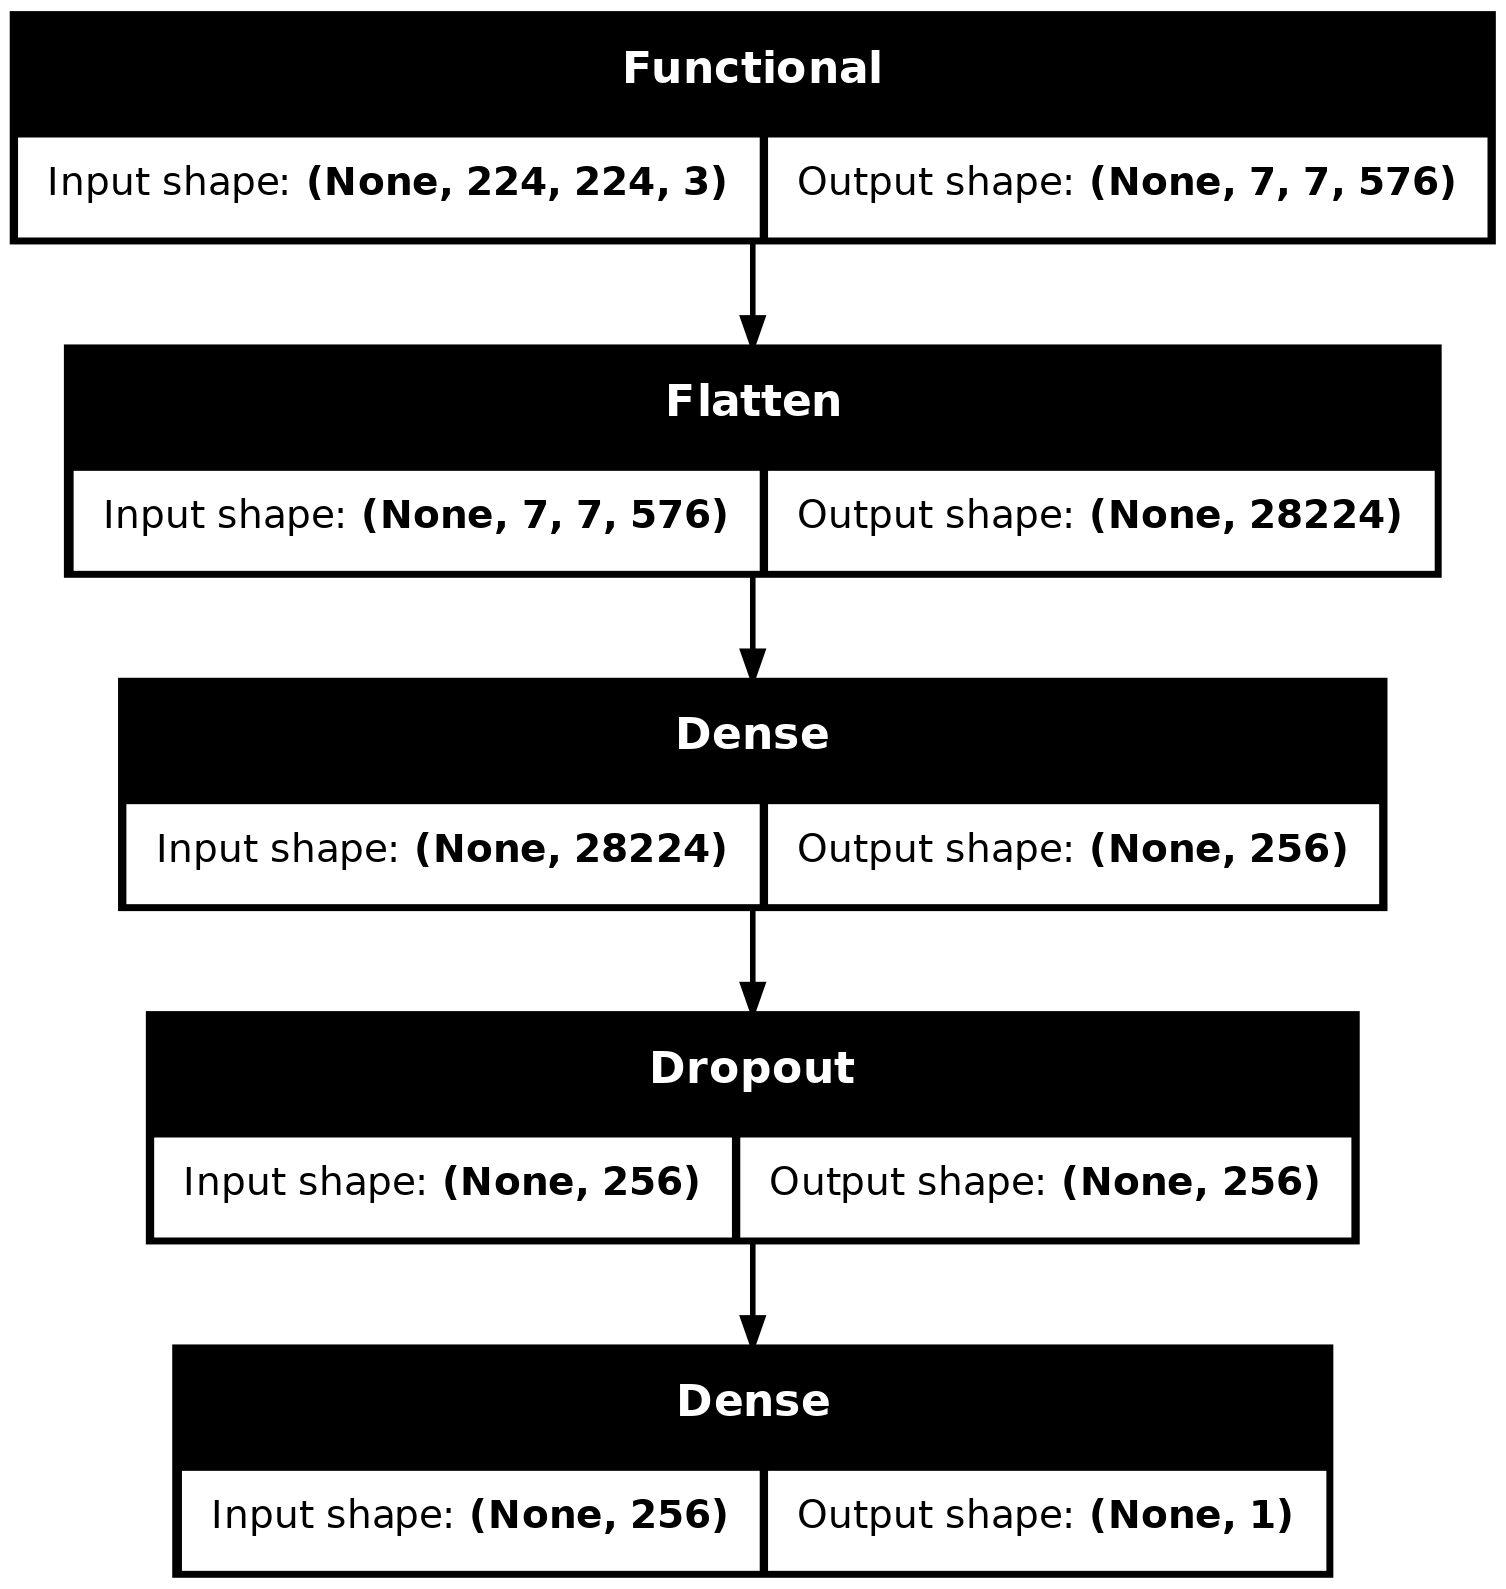

In [30]:
tf.keras.utils.plot_model(model_mobilenet_1, show_shapes=True)

In [32]:
optimizer = Adam(learning_rate=1e-5)
model_mobilenet_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_mobilenet_1, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5470 - loss: 5.5805

2025-01-21 10:24:33.557043: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.5544 - loss: 5.5325 - val_accuracy: 0.4959 - val_loss: 5.0221 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5792 - loss: 4.7936 - val_accuracy: 0.4959 - val_loss: 4.4237 - learning_rate: 1.0000e-05
Epoch 3/100
 97/130 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5842 - loss: 4.2145

2025-01-21 10:24:45.463204: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5880 - loss: 4.1790 - val_accuracy: 0.4959 - val_loss: 3.8610 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5777 - loss: 3.6680 - val_accuracy: 0.4959 - val_loss: 3.4281 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5953 - loss: 3.2378 - val_accuracy: 0.4959 - val_loss: 3.0603 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5943 - loss: 2.8899 - val_accuracy: 0.4959 - val_loss: 2.7026 - learning_rate: 1.0000e-05
Epoch 7/100
 97/130 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5944 - loss: 2.5988

2025-01-21 10:24:56.065377: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5978 - loss: 2.5805 - val_accuracy: 0.4959 - val_loss: 2.4656 - learning_rate: 1.0000e-05
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6005 - loss: 2.3323 - val_accuracy: 0.4959 - val_loss: 2.2328 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5820 - loss: 2.1261 - val_accuracy: 0.4959 - val_loss: 2.0426 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5959 - loss: 1.9449 - val_accuracy: 0.4959 - val_loss: 1.8908 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6037 - loss: 1.7976 - val_accuracy: 0.4959 - val_loss: 1.7419 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5977 - loss: 1.6820 - val_accuracy: 0.4959 - val_loss: 1.6805 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accu

2025-01-21 10:25:17.383494: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6011 - loss: 1.4310 - val_accuracy: 0.4959 - val_loss: 1.4403 - learning_rate: 1.0000e-05
Epoch 16/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5978 - loss: 1.3707 - val_accuracy: 0.4959 - val_loss: 1.4080 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5913 - loss: 1.3291 - val_accuracy: 0.4959 - val_loss: 1.3589 - learning_rate: 1.0000e-05
Epoch 18/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5955 - loss: 1.2824 - val_accuracy: 0.4959 - val_loss: 1.2904 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5958 - loss: 1.2425 - val_accuracy: 0.4959 - val_loss: 1.2579 - learning_rate: 1.0000e-05
Epoch 20/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5965 - loss: 1.2092 - val_accuracy: 0.4959 - val_loss: 1.2322 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - ac

2025-01-21 10:26:02.309665: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5860 - loss: 1.0062 - val_accuracy: 0.4959 - val_loss: 1.0416 - learning_rate: 1.0000e-05
Epoch 32/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6017 - loss: 0.9871 - val_accuracy: 0.4959 - val_loss: 1.0557 - learning_rate: 1.0000e-05
Epoch 33/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5962 - loss: 0.9826 - val_accuracy: 0.4959 - val_loss: 1.0116 - learning_rate: 1.0000e-05
Epoch 34/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5854 - loss: 0.9679 - val_accuracy: 0.4959 - val_loss: 0.9878 - learning_rate: 1.0000e-05
Epoch 35/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5780 - loss: 0.9591 - val_accuracy: 0.4959 - val_loss: 0.9824 - learning_rate: 1.0000e-05
Epoch 36/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5972 - loss: 0.9445 - val_accuracy: 0.4959 - val_loss: 0.9881 - learning_rate: 1.0000e-05
Epoch 37/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - ac

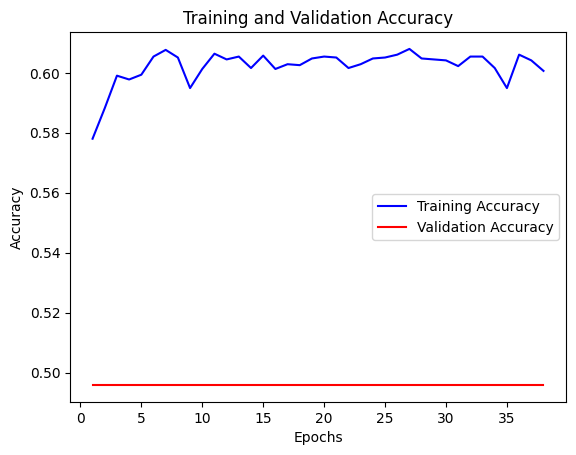

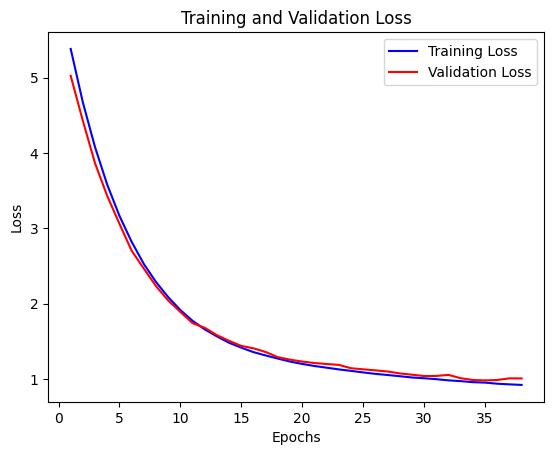

In [34]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

**Model 2**

In [37]:
model_mobilenet_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_mobilenet_2.add(mobilenet_base)

# Add personalized layers
model_mobilenet_2.add(layers.GlobalAveragePooling2D())
model_mobilenet_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_mobilenet_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_mobilenet_2.add(layers.Dense(1, activation='sigmoid'))

model_mobilenet_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,087,089 (4.15 MB)

 Trainable params: 147,969 (578.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

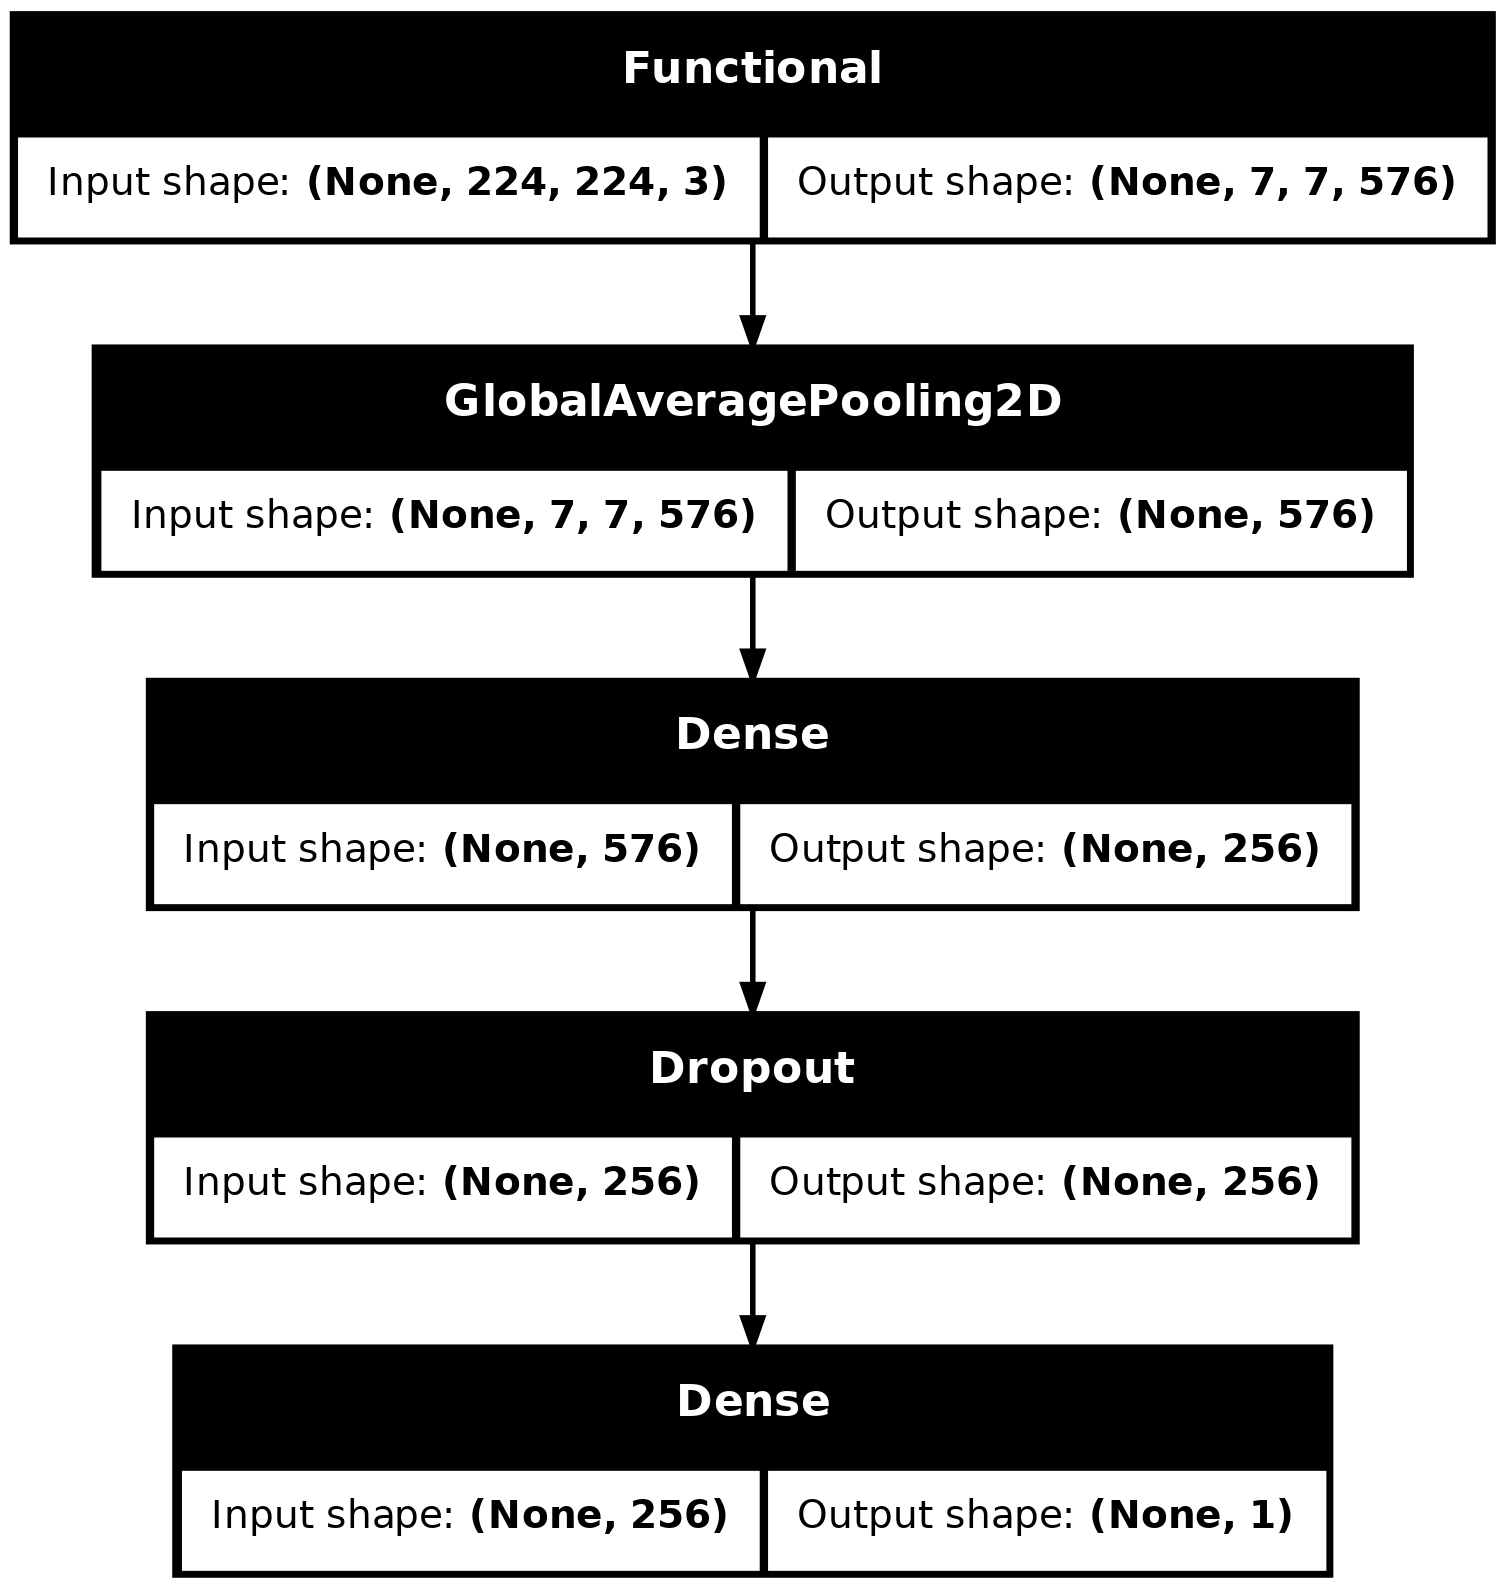

In [38]:
tf.keras.utils.plot_model(model_mobilenet_2, show_shapes=True)

In [41]:
optimizer = Adam(learning_rate=1e-5)
model_mobilenet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_mobilenet_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5333 - loss: 4.2045

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.5377 - loss: 4.1972 - val_accuracy: 0.4959 - val_loss: 4.1436 - learning_rate: 1.0000e-05
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5621 - loss: 4.0886 - val_accuracy: 0.4959 - val_loss: 4.0454 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5877 - loss: 3.9815 - val_accuracy: 0.4959 - val_loss: 3.9446 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5880 - loss: 3.8814 - val_accuracy: 0.4959 - val_loss: 3.8467 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5717 - loss: 3.7912 - val_accuracy: 0.4959 - val_loss: 3.7544 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5853 - loss: 3.6891 - val_accuracy: 0.4959 - val_loss: 3.6630 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accurac

2025-01-21 10:36:09.829484: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5866 - loss: 2.3289 - val_accuracy: 0.4959 - val_loss: 2.3263 - learning_rate: 1.0000e-05
Epoch 26/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5841 - loss: 2.2728 - val_accuracy: 0.4959 - val_loss: 2.2744 - learning_rate: 1.0000e-05
Epoch 27/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5869 - loss: 2.2229 - val_accuracy: 0.4959 - val_loss: 2.2247 - learning_rate: 1.0000e-05
Epoch 28/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5896 - loss: 2.1739 - val_accuracy: 0.4959 - val_loss: 2.1743 - learning_rate: 1.0000e-05
Epoch 29/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5931 - loss: 2.1217 - val_accuracy: 0.4959 - val_loss: 2.1262 - learning_rate: 1.0000e-05
Epoch 30/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5903 - loss: 2.0735 - val_accuracy: 0.4959 - val_loss: 2.0798 - learning_rate: 1.0000e-05
Epoch 31/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - ac

2025-01-21 10:39:01.776650: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5914 - loss: 0.8655 - val_accuracy: 0.4959 - val_loss: 0.8993 - learning_rate: 1.0000e-05
Epoch 90/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5955 - loss: 0.8586 - val_accuracy: 0.4959 - val_loss: 0.8961 - learning_rate: 1.0000e-05
Epoch 91/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5931 - loss: 0.8547 - val_accuracy: 0.4959 - val_loss: 0.8922 - learning_rate: 1.0000e-05
Epoch 92/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5962 - loss: 0.8475

2025-01-21 10:39:09.657969: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10066852914645577579
2025-01-21 10:39:09.658012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12202429157183213358


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5987 - loss: 0.8466 - val_accuracy: 0.4959 - val_loss: 0.8875 - learning_rate: 1.0000e-05
Epoch 93/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5972 - loss: 0.8426 - val_accuracy: 0.4959 - val_loss: 0.8825 - learning_rate: 1.0000e-05
Epoch 94/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5962 - loss: 0.8431

2025-01-21 10:39:14.901396: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10066852914645577579
2025-01-21 10:39:14.901422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12202429157183213358


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5986 - loss: 0.8415 - val_accuracy: 0.4959 - val_loss: 0.8791 - learning_rate: 1.0000e-05
Epoch 95/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5944 - loss: 0.8377 - val_accuracy: 0.4959 - val_loss: 0.8744 - learning_rate: 1.0000e-05
Epoch 96/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5970 - loss: 0.8319 - val_accuracy: 0.4959 - val_loss: 0.8728 - learning_rate: 1.0000e-05
Epoch 97/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5972 - loss: 0.8286 - val_accuracy: 0.4959 - val_loss: 0.8688 - learning_rate: 1.0000e-05
Epoch 98/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5947 - loss: 0.8278 - val_accuracy: 0.4959 - val_loss: 0.8651 - learning_rate: 1.0000e-05
Epoch 99/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5955 - loss: 0.8232 - val_accuracy: 0.4959 - val_loss: 0.8629 - learning_rate: 1.0000e-05
Epoch 100/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - a

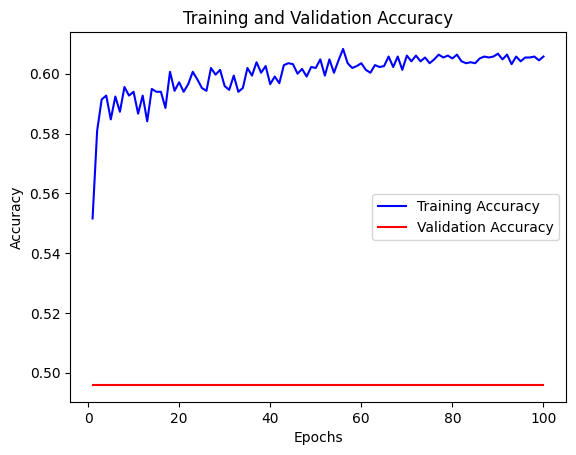

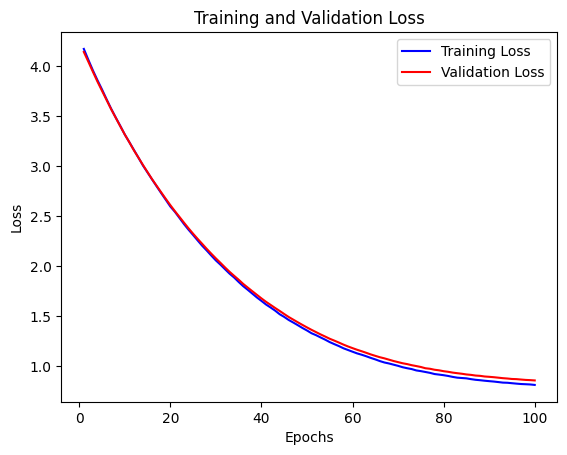

In [43]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)